# Support Vector Machines 


## Fraud in Wine

Wine fraud relates to the commercial aspects of wine. The most prevalent type of fraud is one where wines are adulterated, usually with the addition of cheaper products (e.g. juices) and sometimes with harmful chemicals and sweeteners (compensating for color or flavor).

Counterfeiting and the relabelling of inferior and cheaper wines to more expensive brands is another common type of wine fraud.

<img src="images/wine.jpg">

## Project Goals

A distribution company that was recently a victim of fraud has completed an audit of various samples of wine through the use of chemical analysis on samples. The distribution company specializes in exporting extremely high quality, expensive wines, but was defrauded by a supplier who was attempting to pass off cheap, low quality wine as higher grade wine. The distribution company has hired you to attempt to create a machine learning model that can help detect low quality (a.k.a "fraud") wine samples. They want to know if it is even possible to detect such a difference.


Data Source: *P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553, 2009.*

---
---

**TASK: Our overall goal is to use the wine dataset shown below to develop a machine learning model that attempts to predict if a wine is "Legit" or "Fraud" based on various chemical features**

---
---

## Data Setup and Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from joblib import dump,load


In [2]:
df = pd.read_csv("DATA/wine_fraud.csv")

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Legit,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Legit,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Legit,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Legit,red


In [4]:
df.shape

(6497, 13)

**What are the unique variables in the target column we are trying to predict (quality)?**

In [5]:
df['quality'].unique()

array(['Legit', 'Fraud'], dtype=object)

##  Exploratory Data Analysis

### 1. Class Balance  
Here we look at how many “Legit” and “Fraud” samples we have.  If the classes are highly imbalanced, we may need to account for that in our modeling.

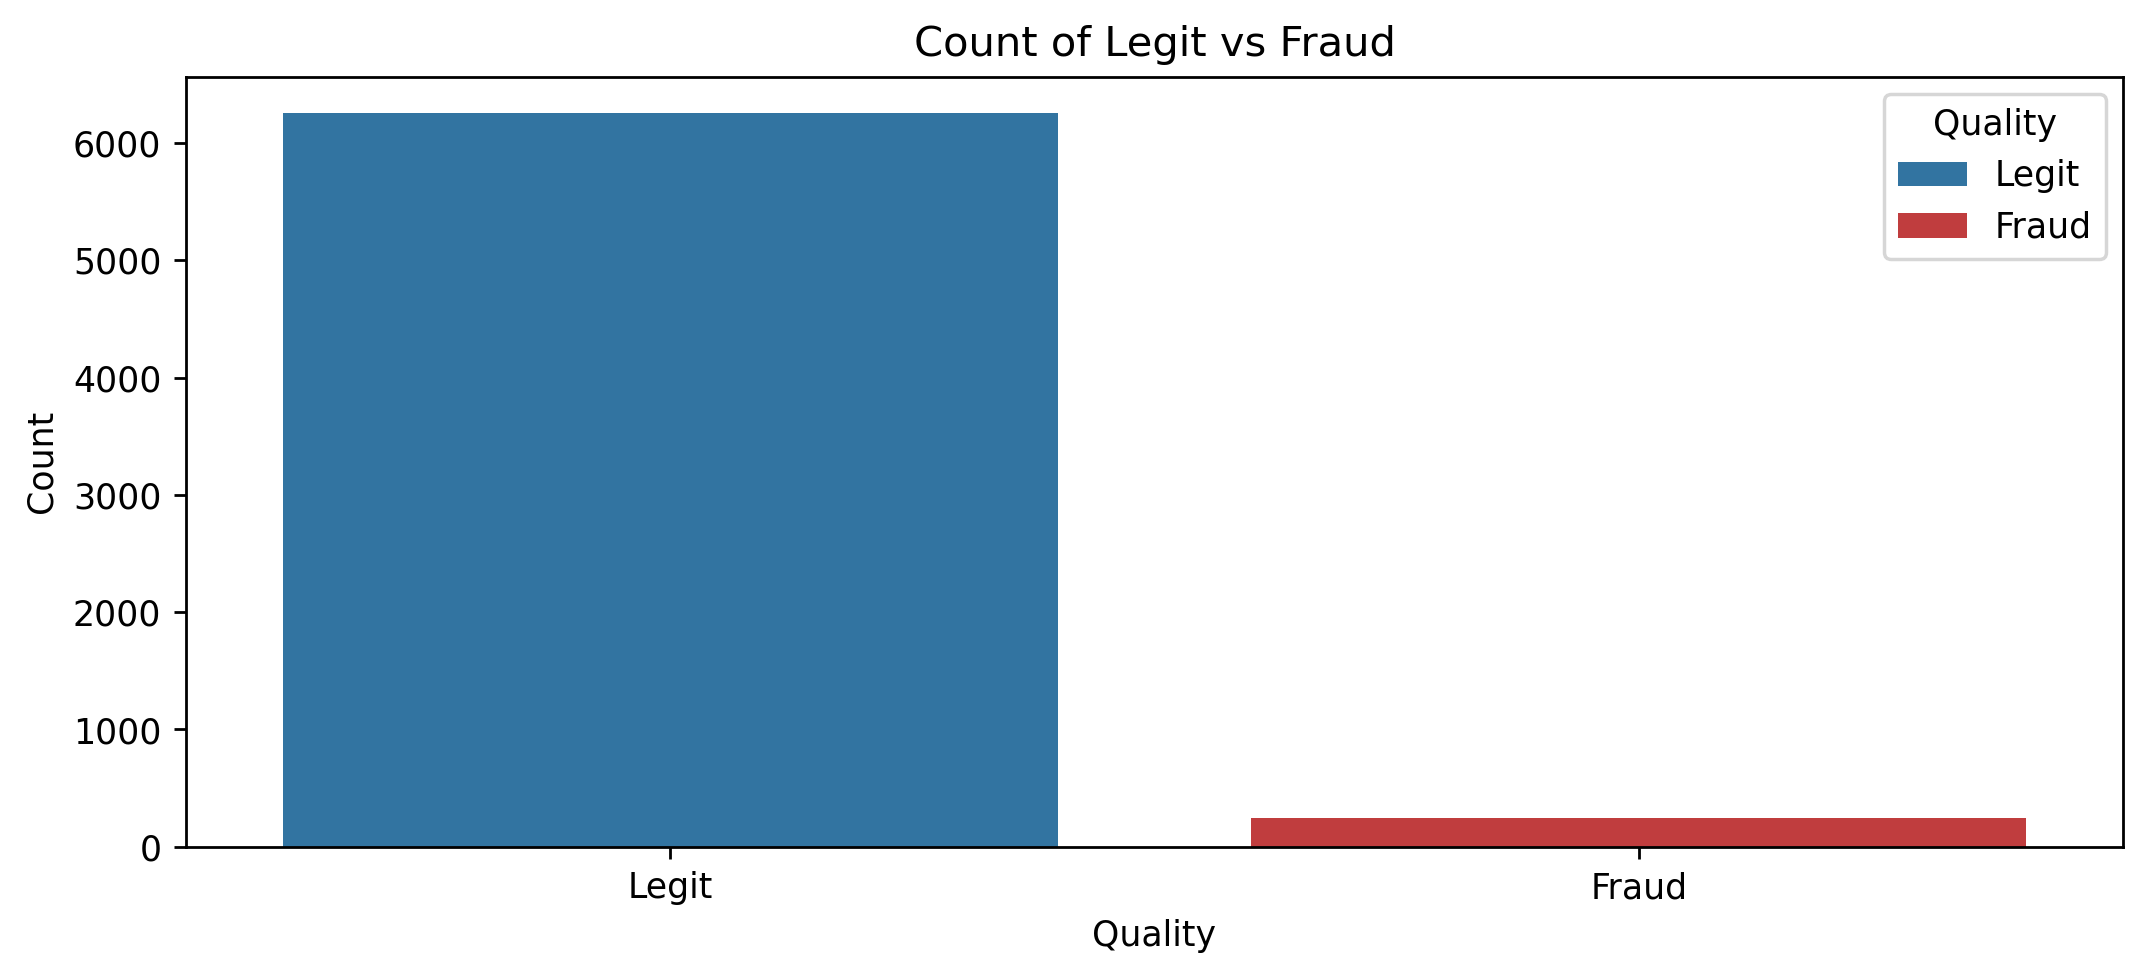

In [6]:
plt.figure(figsize=(10,4),dpi=250)
sns.countplot(x='quality', data=df,hue="quality" ,palette=['C0','C3'])
plt.title("Count of Legit vs Fraud")
plt.ylabel("Count")
plt.xlabel("Quality")
plt.legend(title="Quality", labels=["Legit", "Fraud"])
plt.savefig("visualizations/wine_fraud_countplot.png")

### 2. Fraud Rate by Red vs White  
It can be insightful to see if one wine type is more frequently counterfeited than the other.

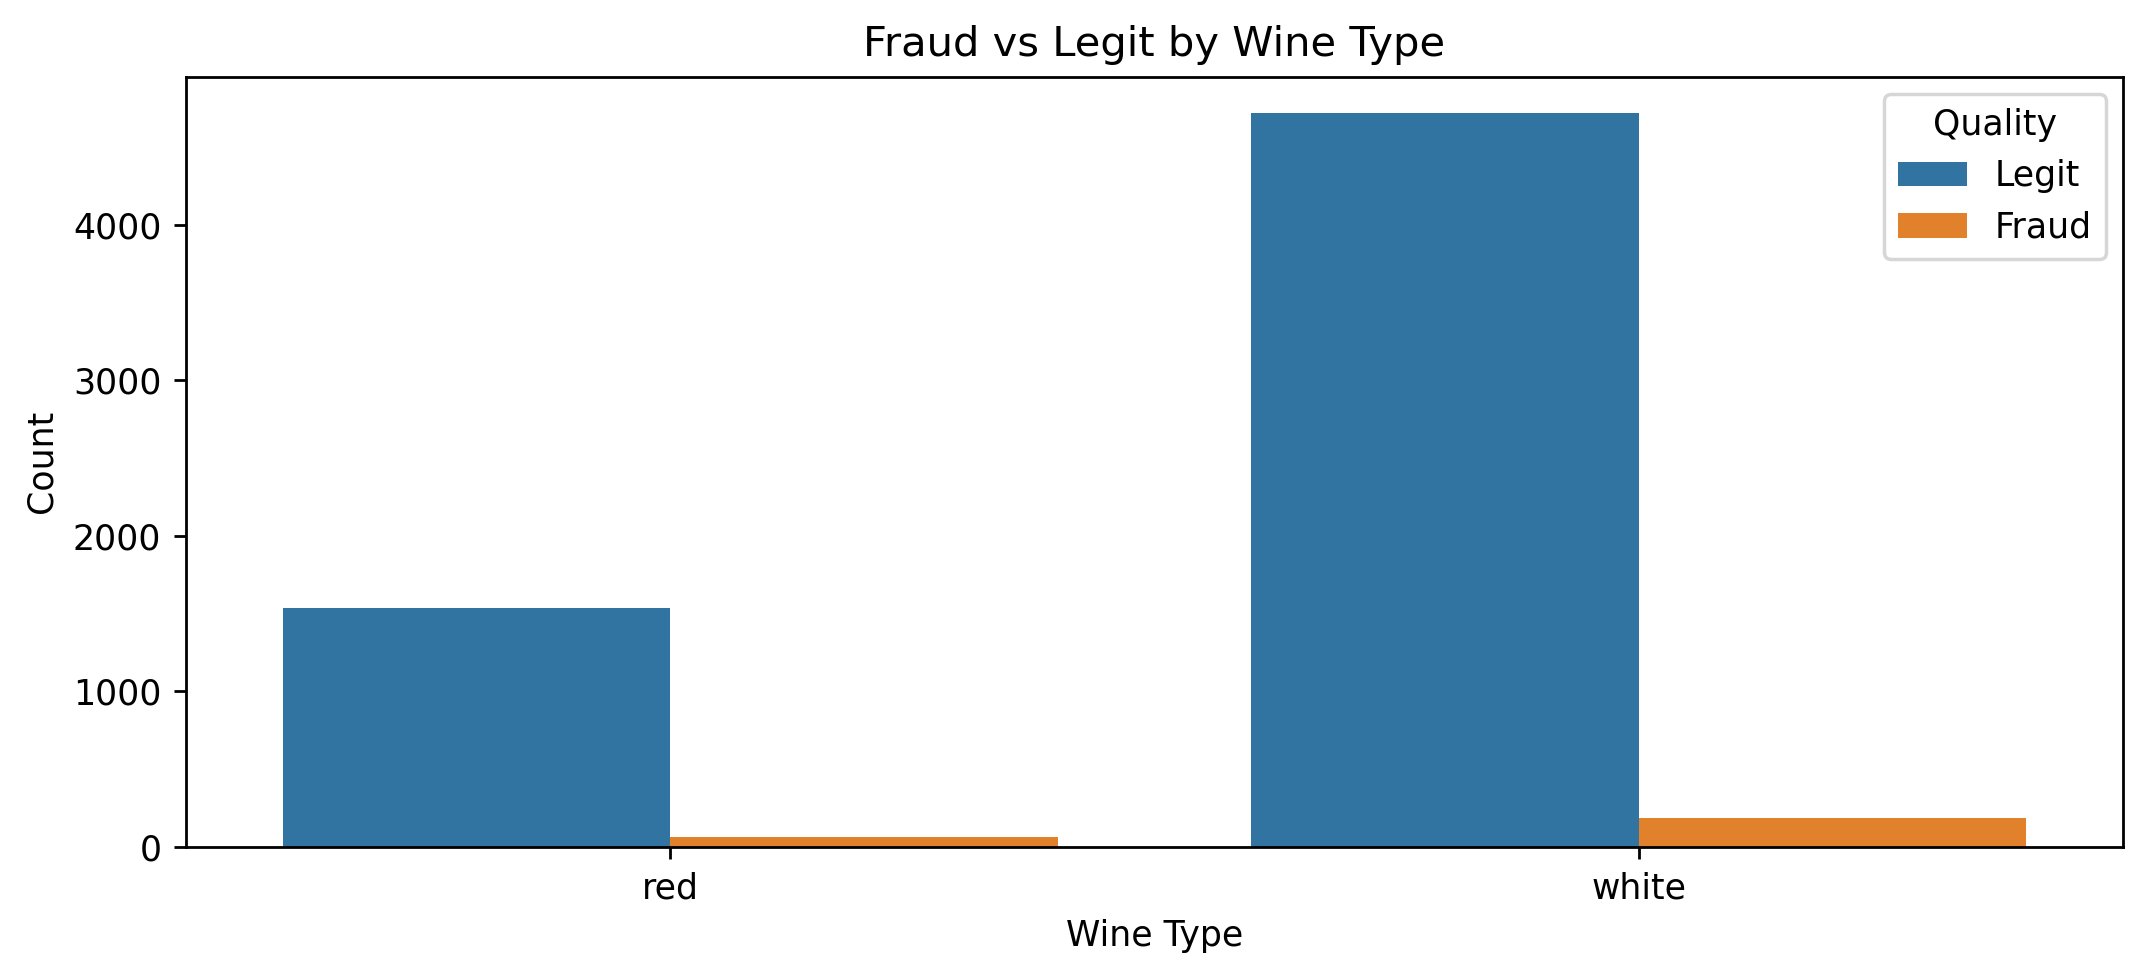

In [7]:
plt.figure(figsize=(10,4),dpi=250)
sns.countplot(x='type', hue='quality', data=df)
plt.title("Fraud vs Legit by Wine Type")
plt.xlabel("Wine Type")
plt.ylabel("Count")
plt.legend(title="Quality", labels=["Legit", "Fraud"])
plt.savefig("visualizations/wine_fraud_type_countplot.png")

**What percentage of red wines are Fraud? What percentage of white wines are fraud?**

In [8]:
reds = df[df["type"]=='red']
whites = df[df["type"]=='white']

print("Percentage of fraud in Red Wines:")
print(100* (len(reds[reds['quality']=='Fraud'])/len(reds)))

print("Percentage of fraud in White Wines:")
print(100* (len(whites[whites['quality']=='Fraud'])/len(whites)))

Percentage of fraud in Red Wines:
3.9399624765478425
Percentage of fraud in White Wines:
3.7362188648427925


### 3. Feature Distributions  
Plotting the raw distributions of features like alcohol, pH, and sulphates can reveal skew, outliers, or bi-modal behavior.

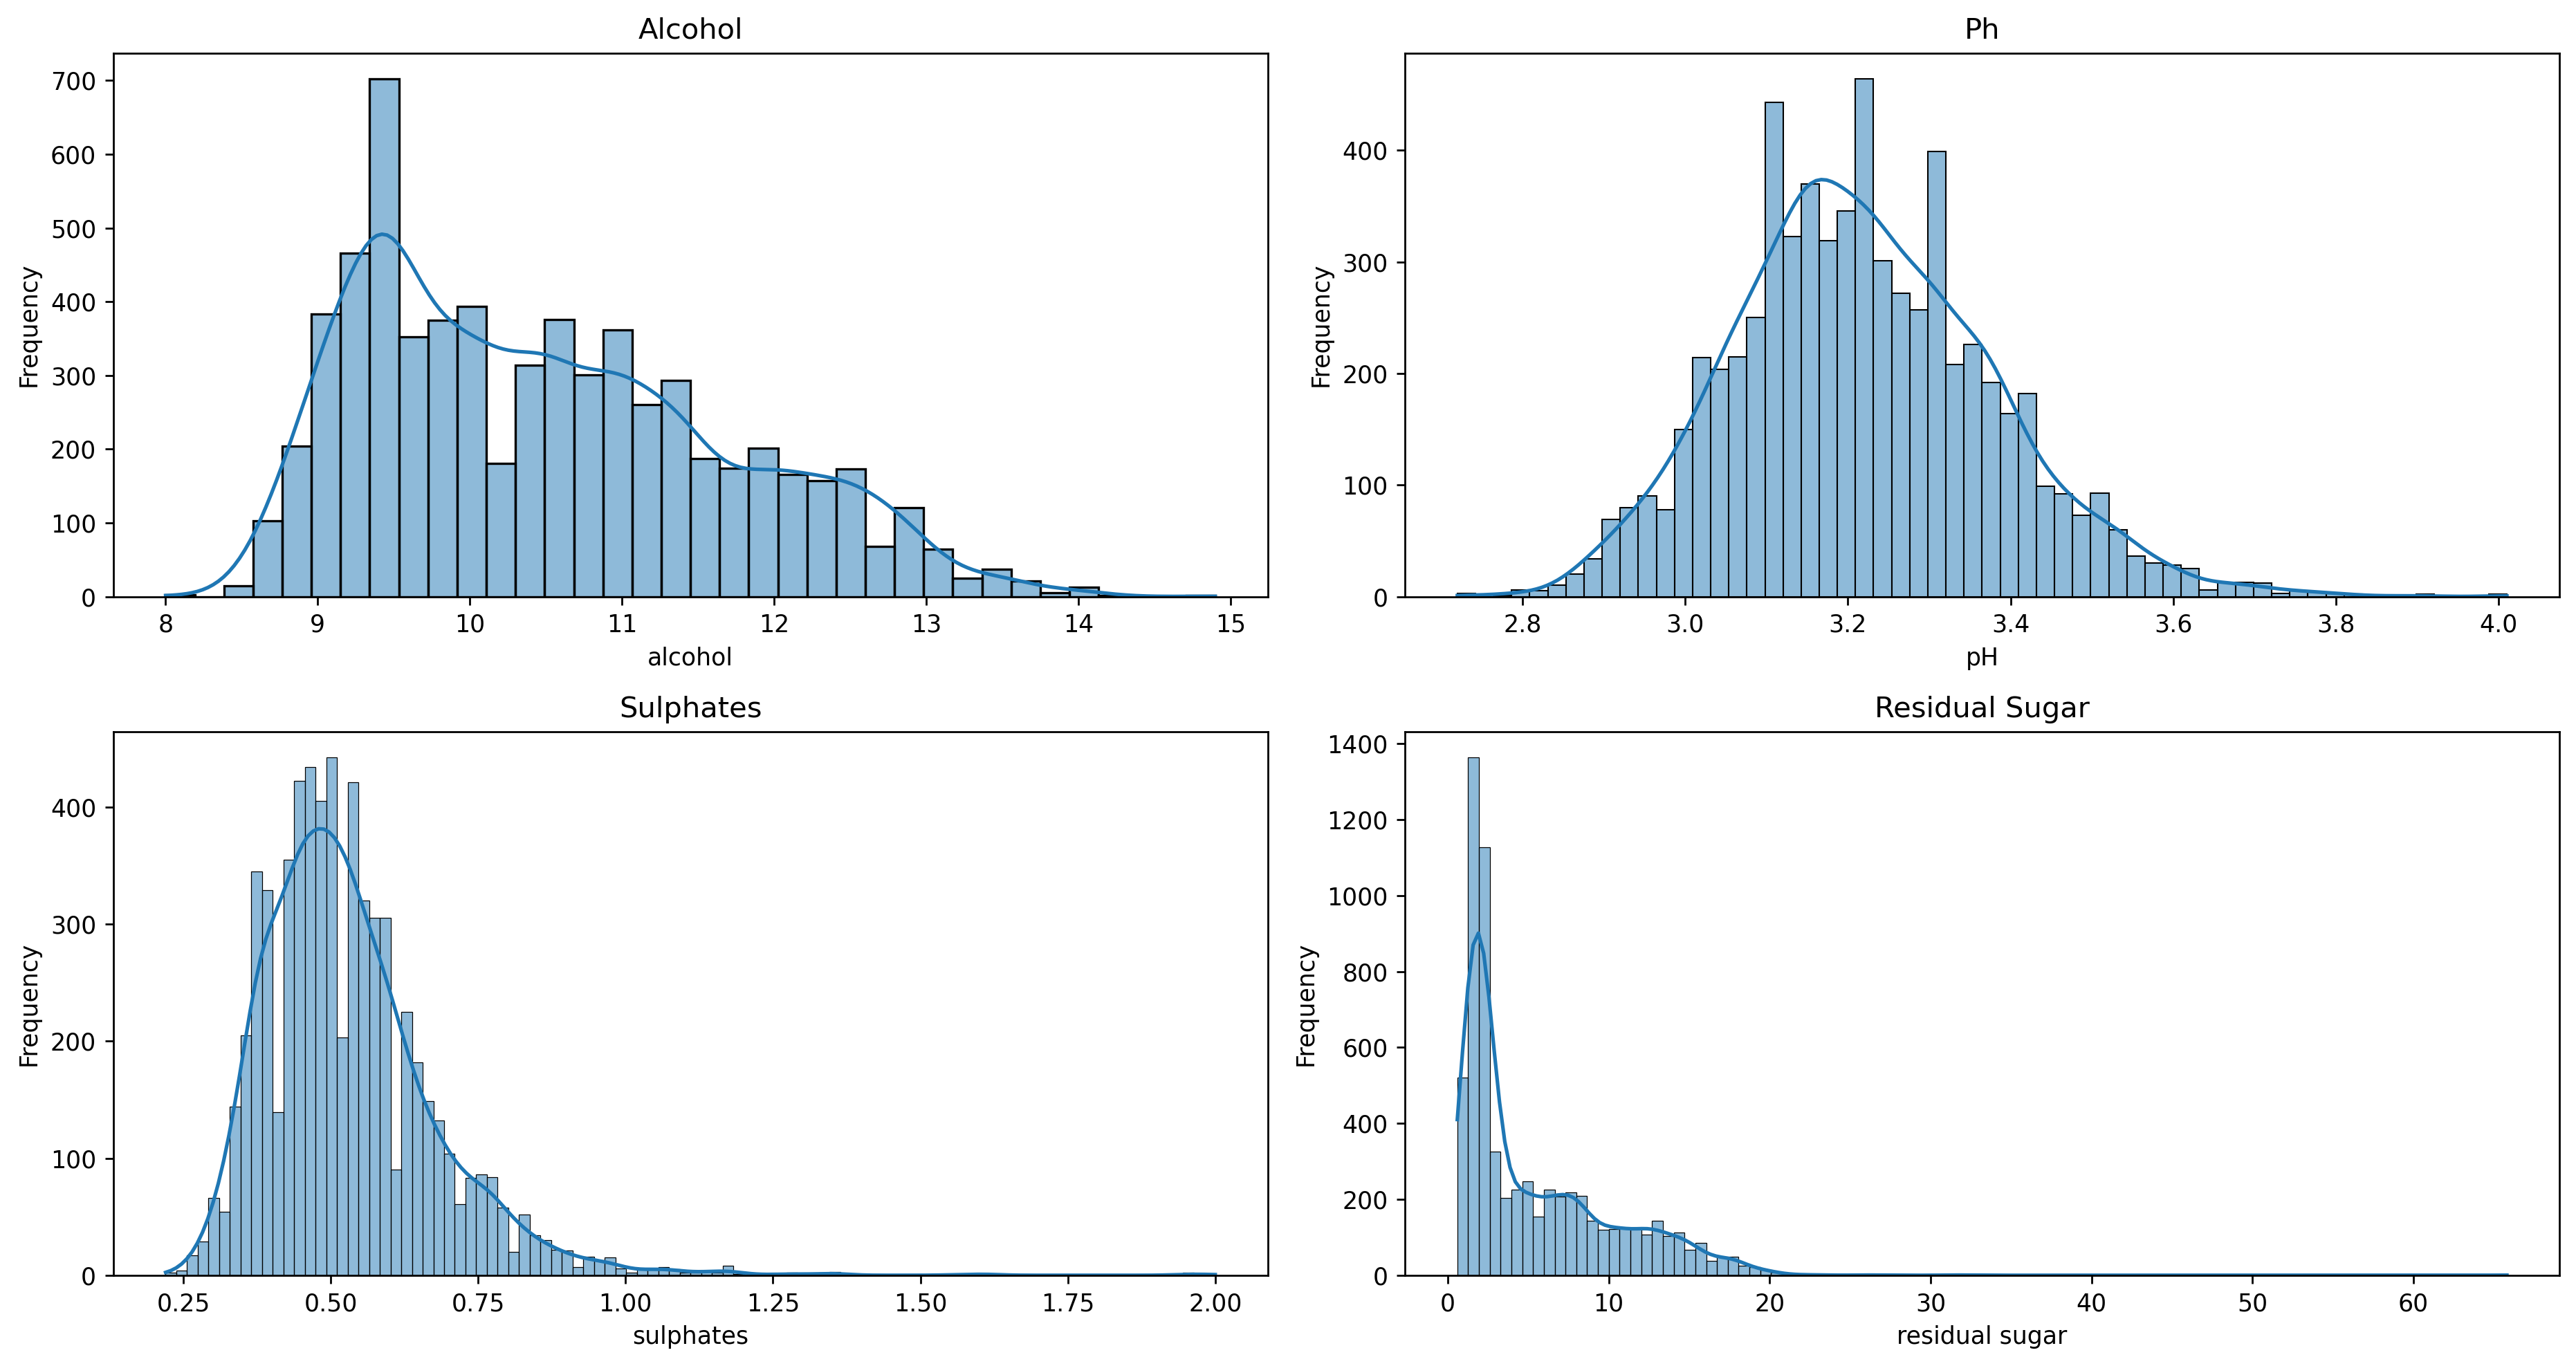

In [9]:
numeric = ['alcohol','pH','sulphates','residual sugar']
plt.figure(figsize=(15,8),dpi=250)
for i, feat in enumerate(numeric,1):
    plt.subplot(2,2,i)
    sns.histplot(df[feat], kde=True)
    plt.title(feat.title()) 
    plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("visualizations/wine_fraud_feature_distributions.png")


### 4. Boxplots by Class  
Here we compare the distribution of, for example, alcohol and sulphates between Legit and Fraud samples to see if there are visible shifts.

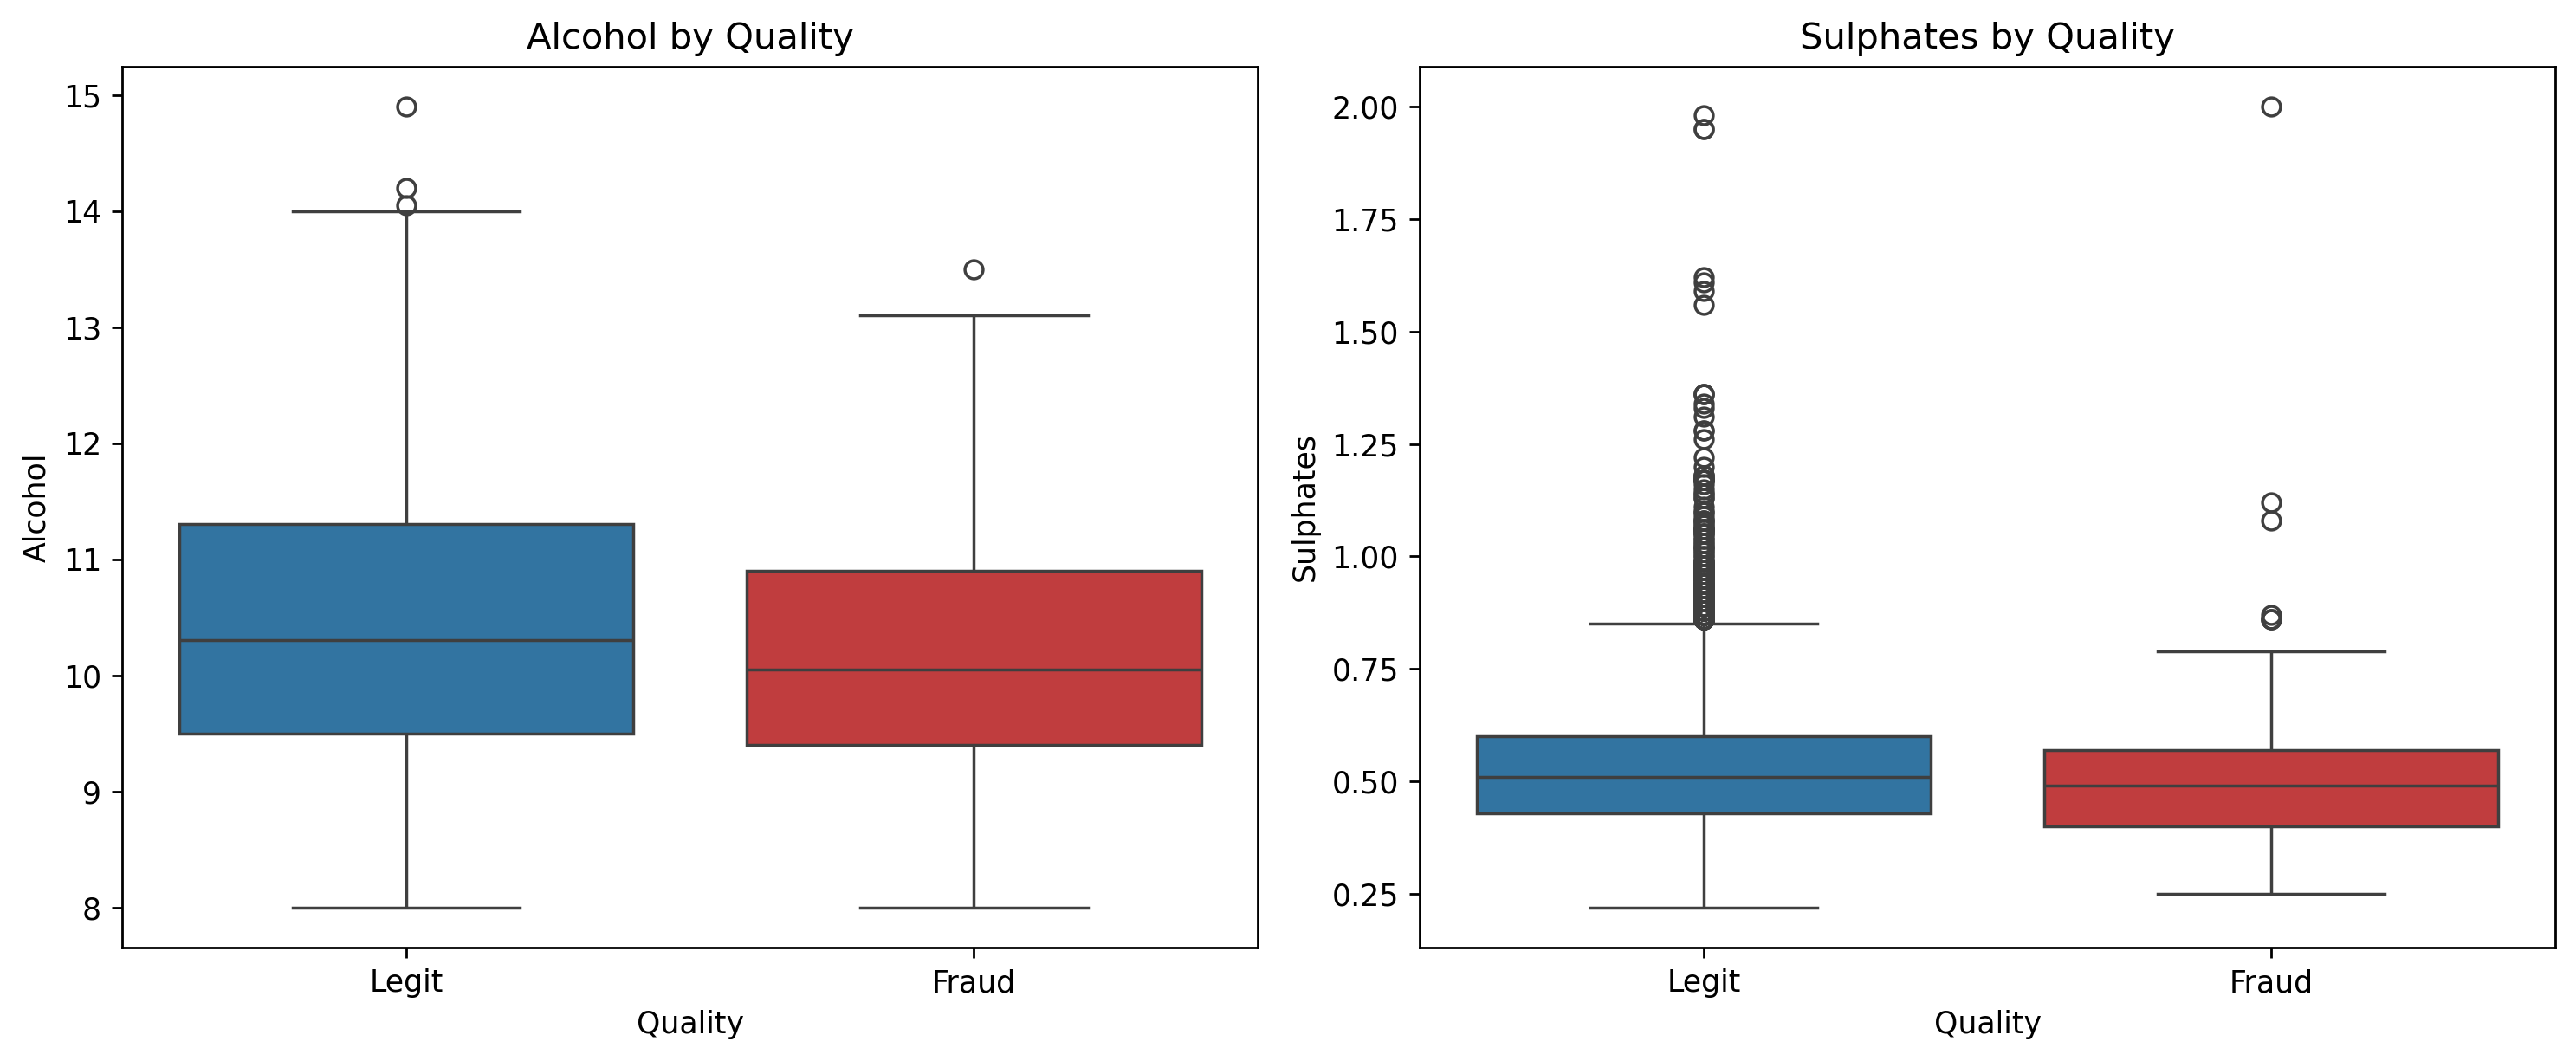

In [10]:
plt.figure(figsize=(12,5),dpi=250)
for i, feat in enumerate(['alcohol','sulphates'],1):
    plt.subplot(1,2,i)
    sns.boxplot(x='quality', y=feat, data=df,hue="quality",palette=['C0','C3'])
    plt.title(f"{feat.title()} by Quality")
    plt.xlabel("Quality")
    plt.ylabel(feat.title())
plt.tight_layout()
plt.savefig("visualizations/wine_fraud_boxplots.png")


**Let's calculate the correlation between the various features and the "quality" column.**

In [11]:
df['Fraud']= df['quality'].map({'Legit':0,'Fraud':1})
df.select_dtypes('number').corr()['Fraud']

fixed acidity           0.021794
volatile acidity        0.151228
citric acid            -0.061789
residual sugar         -0.048756
chlorides               0.034499
free sulfur dioxide    -0.085204
total sulfur dioxide   -0.035252
density                 0.016351
pH                      0.020107
sulphates              -0.034046
alcohol                -0.051141
Fraud                   1.000000
Name: Fraud, dtype: float64

### 5. Feature Correlations  
A heatmap of the correlation matrix lets us spot highly correlated inputs (and any surprising relationships with Fraud).

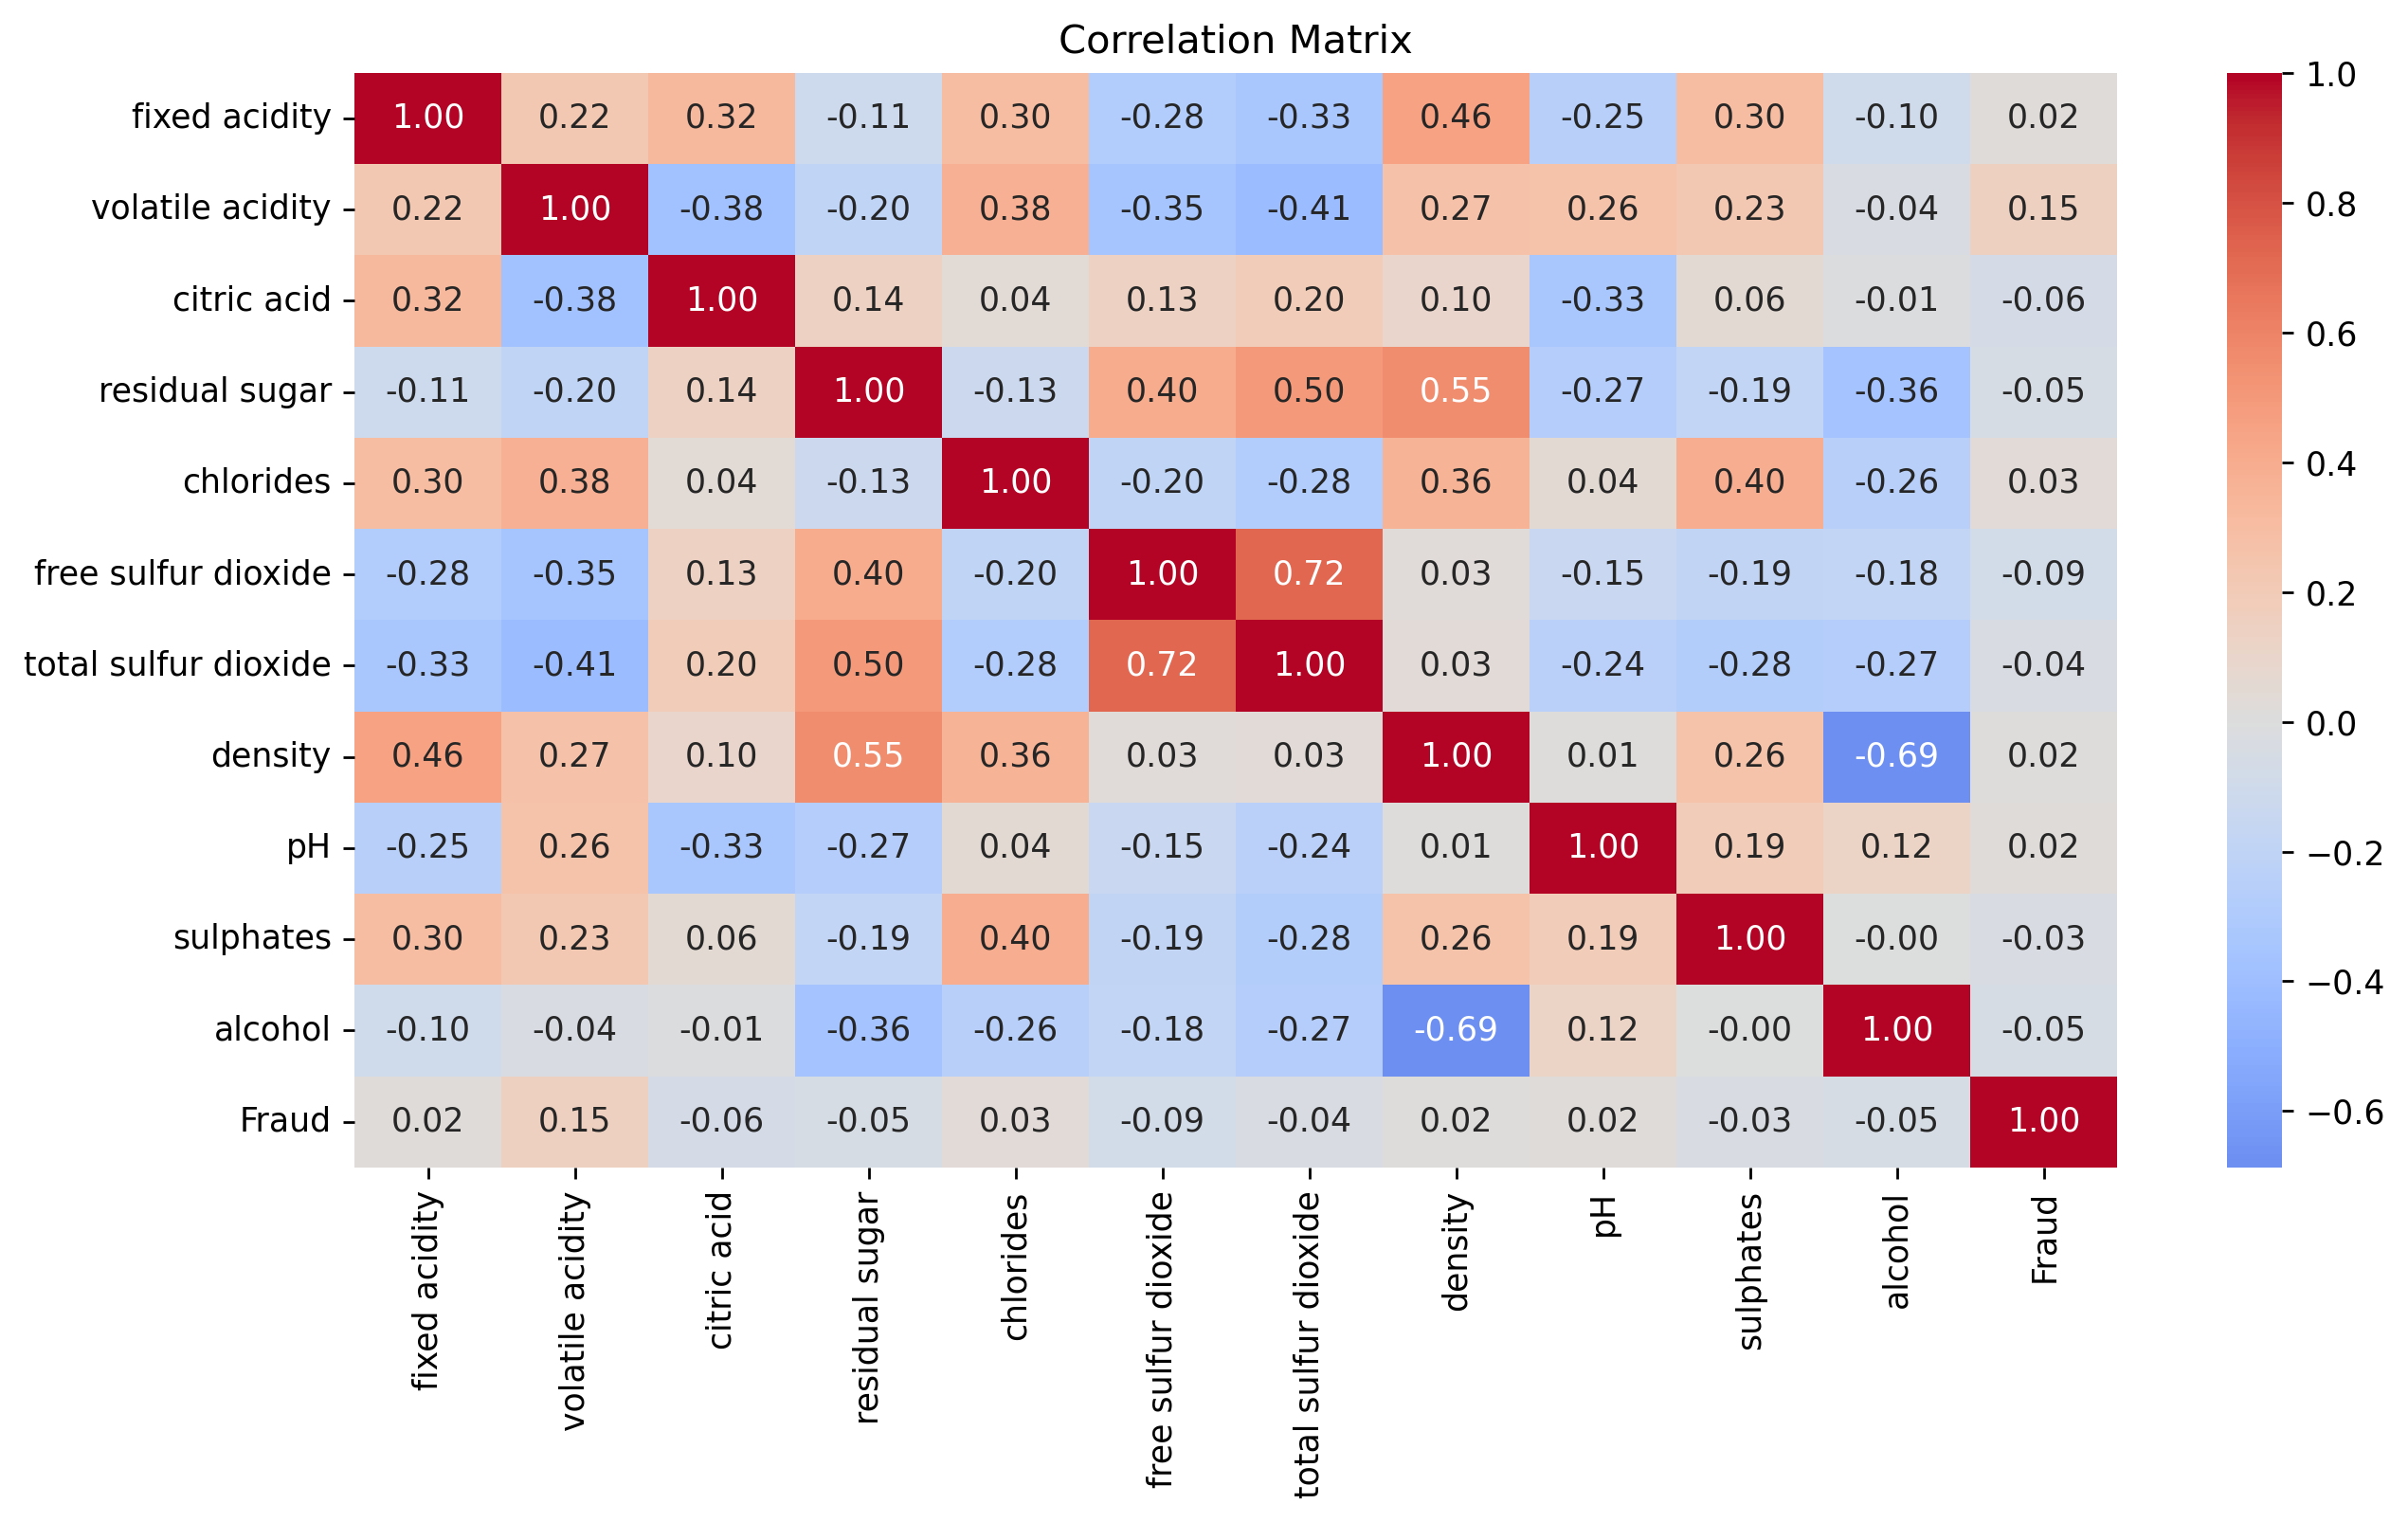

In [12]:
plt.figure(figsize=(12,6),dpi=250)
corr = df.select_dtypes('number').corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.savefig("visualizations/wine_fraud_correlation_heatmap.png")


**Create a bar plot of the correlation values to Fraudlent wine.**

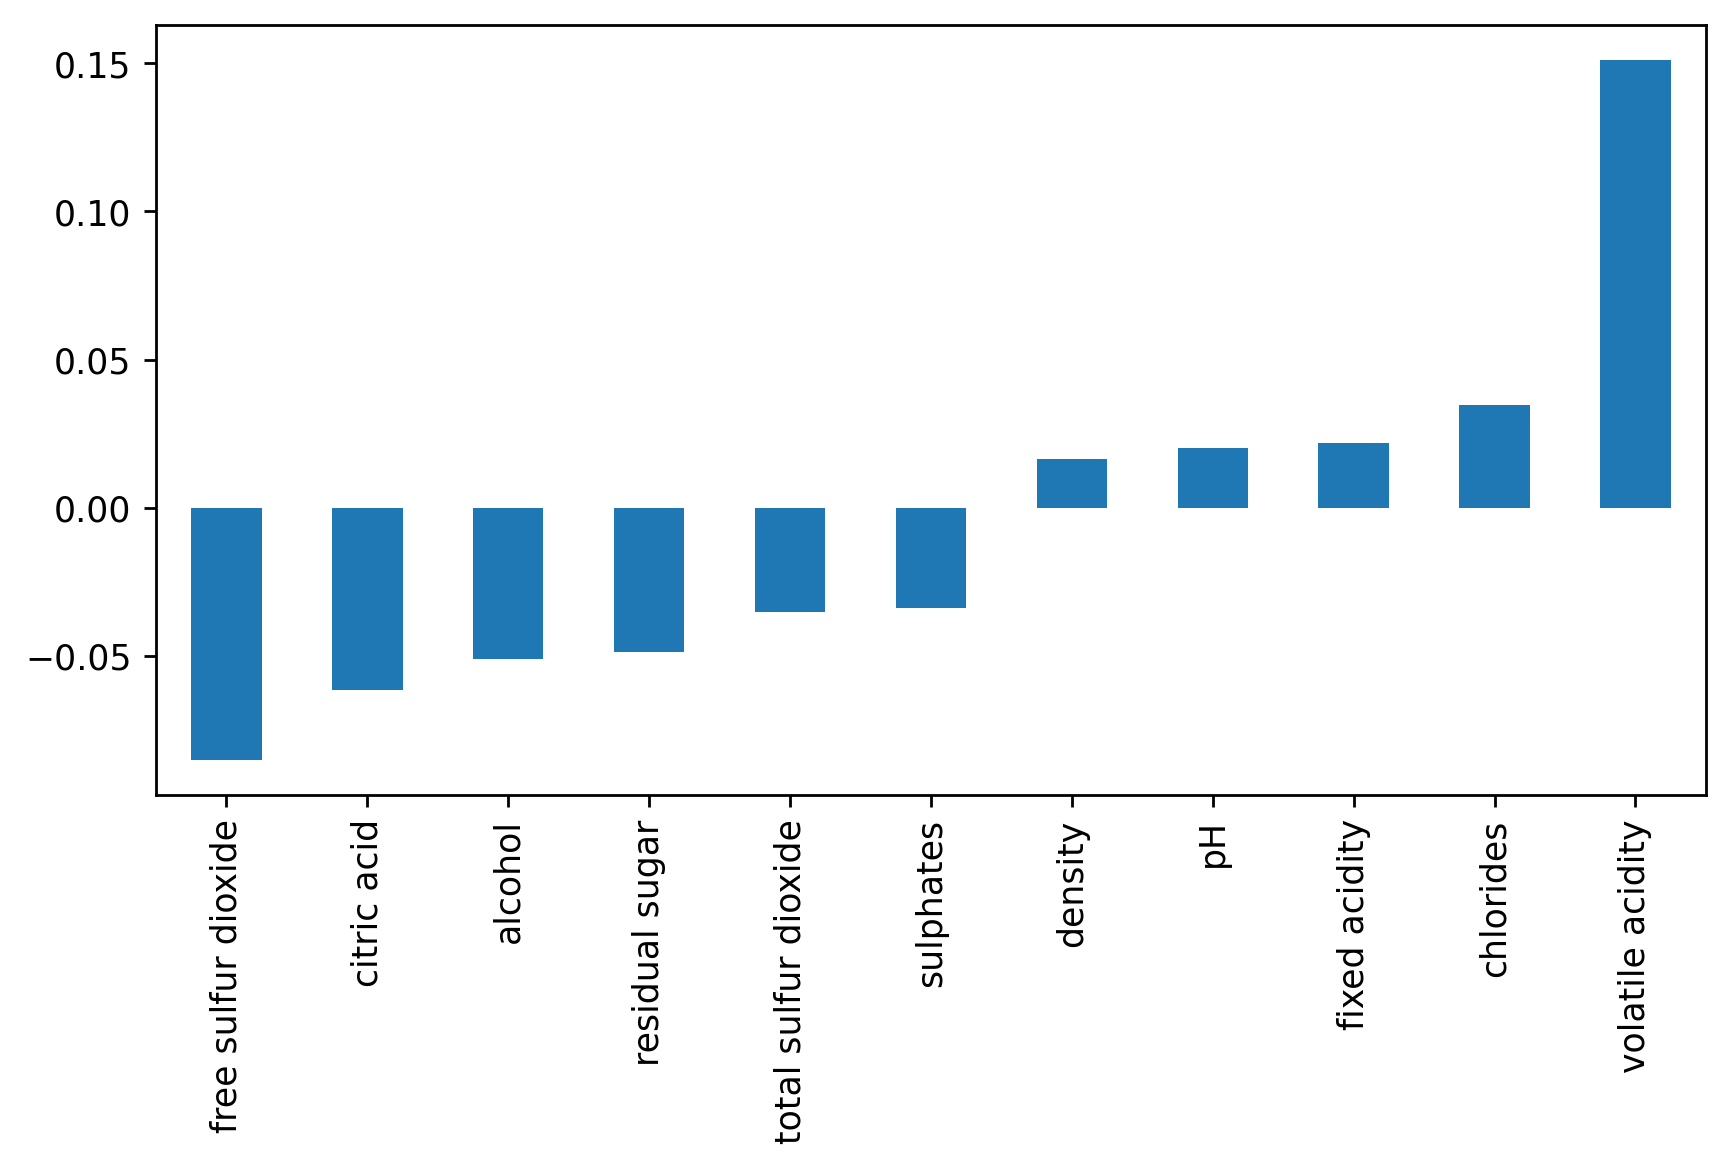

In [13]:
plt.figure(figsize=(8,4),dpi=250)
corr['Fraud'][:-1].sort_values().plot(kind='bar')
plt.savefig("visualizations/wine_fraud_correlation_barplot.png")


### 7. Pairwise Relationships  
A pairplot (on a handful of key variables) can reveal clusters or separation between classes in feature space.

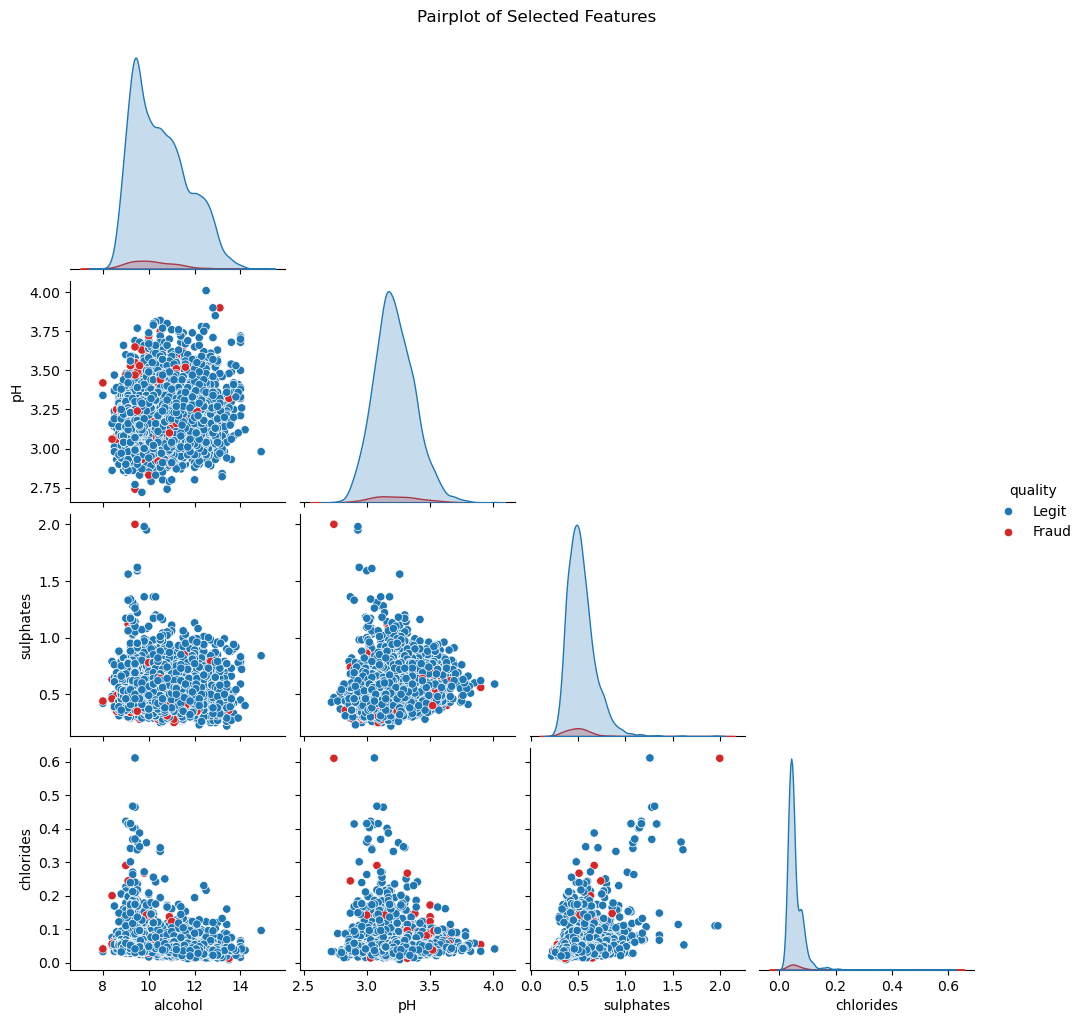

In [14]:
sns.pairplot(df, hue='quality', vars=['alcohol','pH','sulphates','chlorides'],
             palette=['C0','C3'], diag_kind='kde', corner=True)
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.savefig("visualizations/wine_fraud_pairplot.png")


### 8. Violin Plots  
Violin plots show the full distribution shape (density) of features across Legit vs Fraud, making subtle differences stand out.


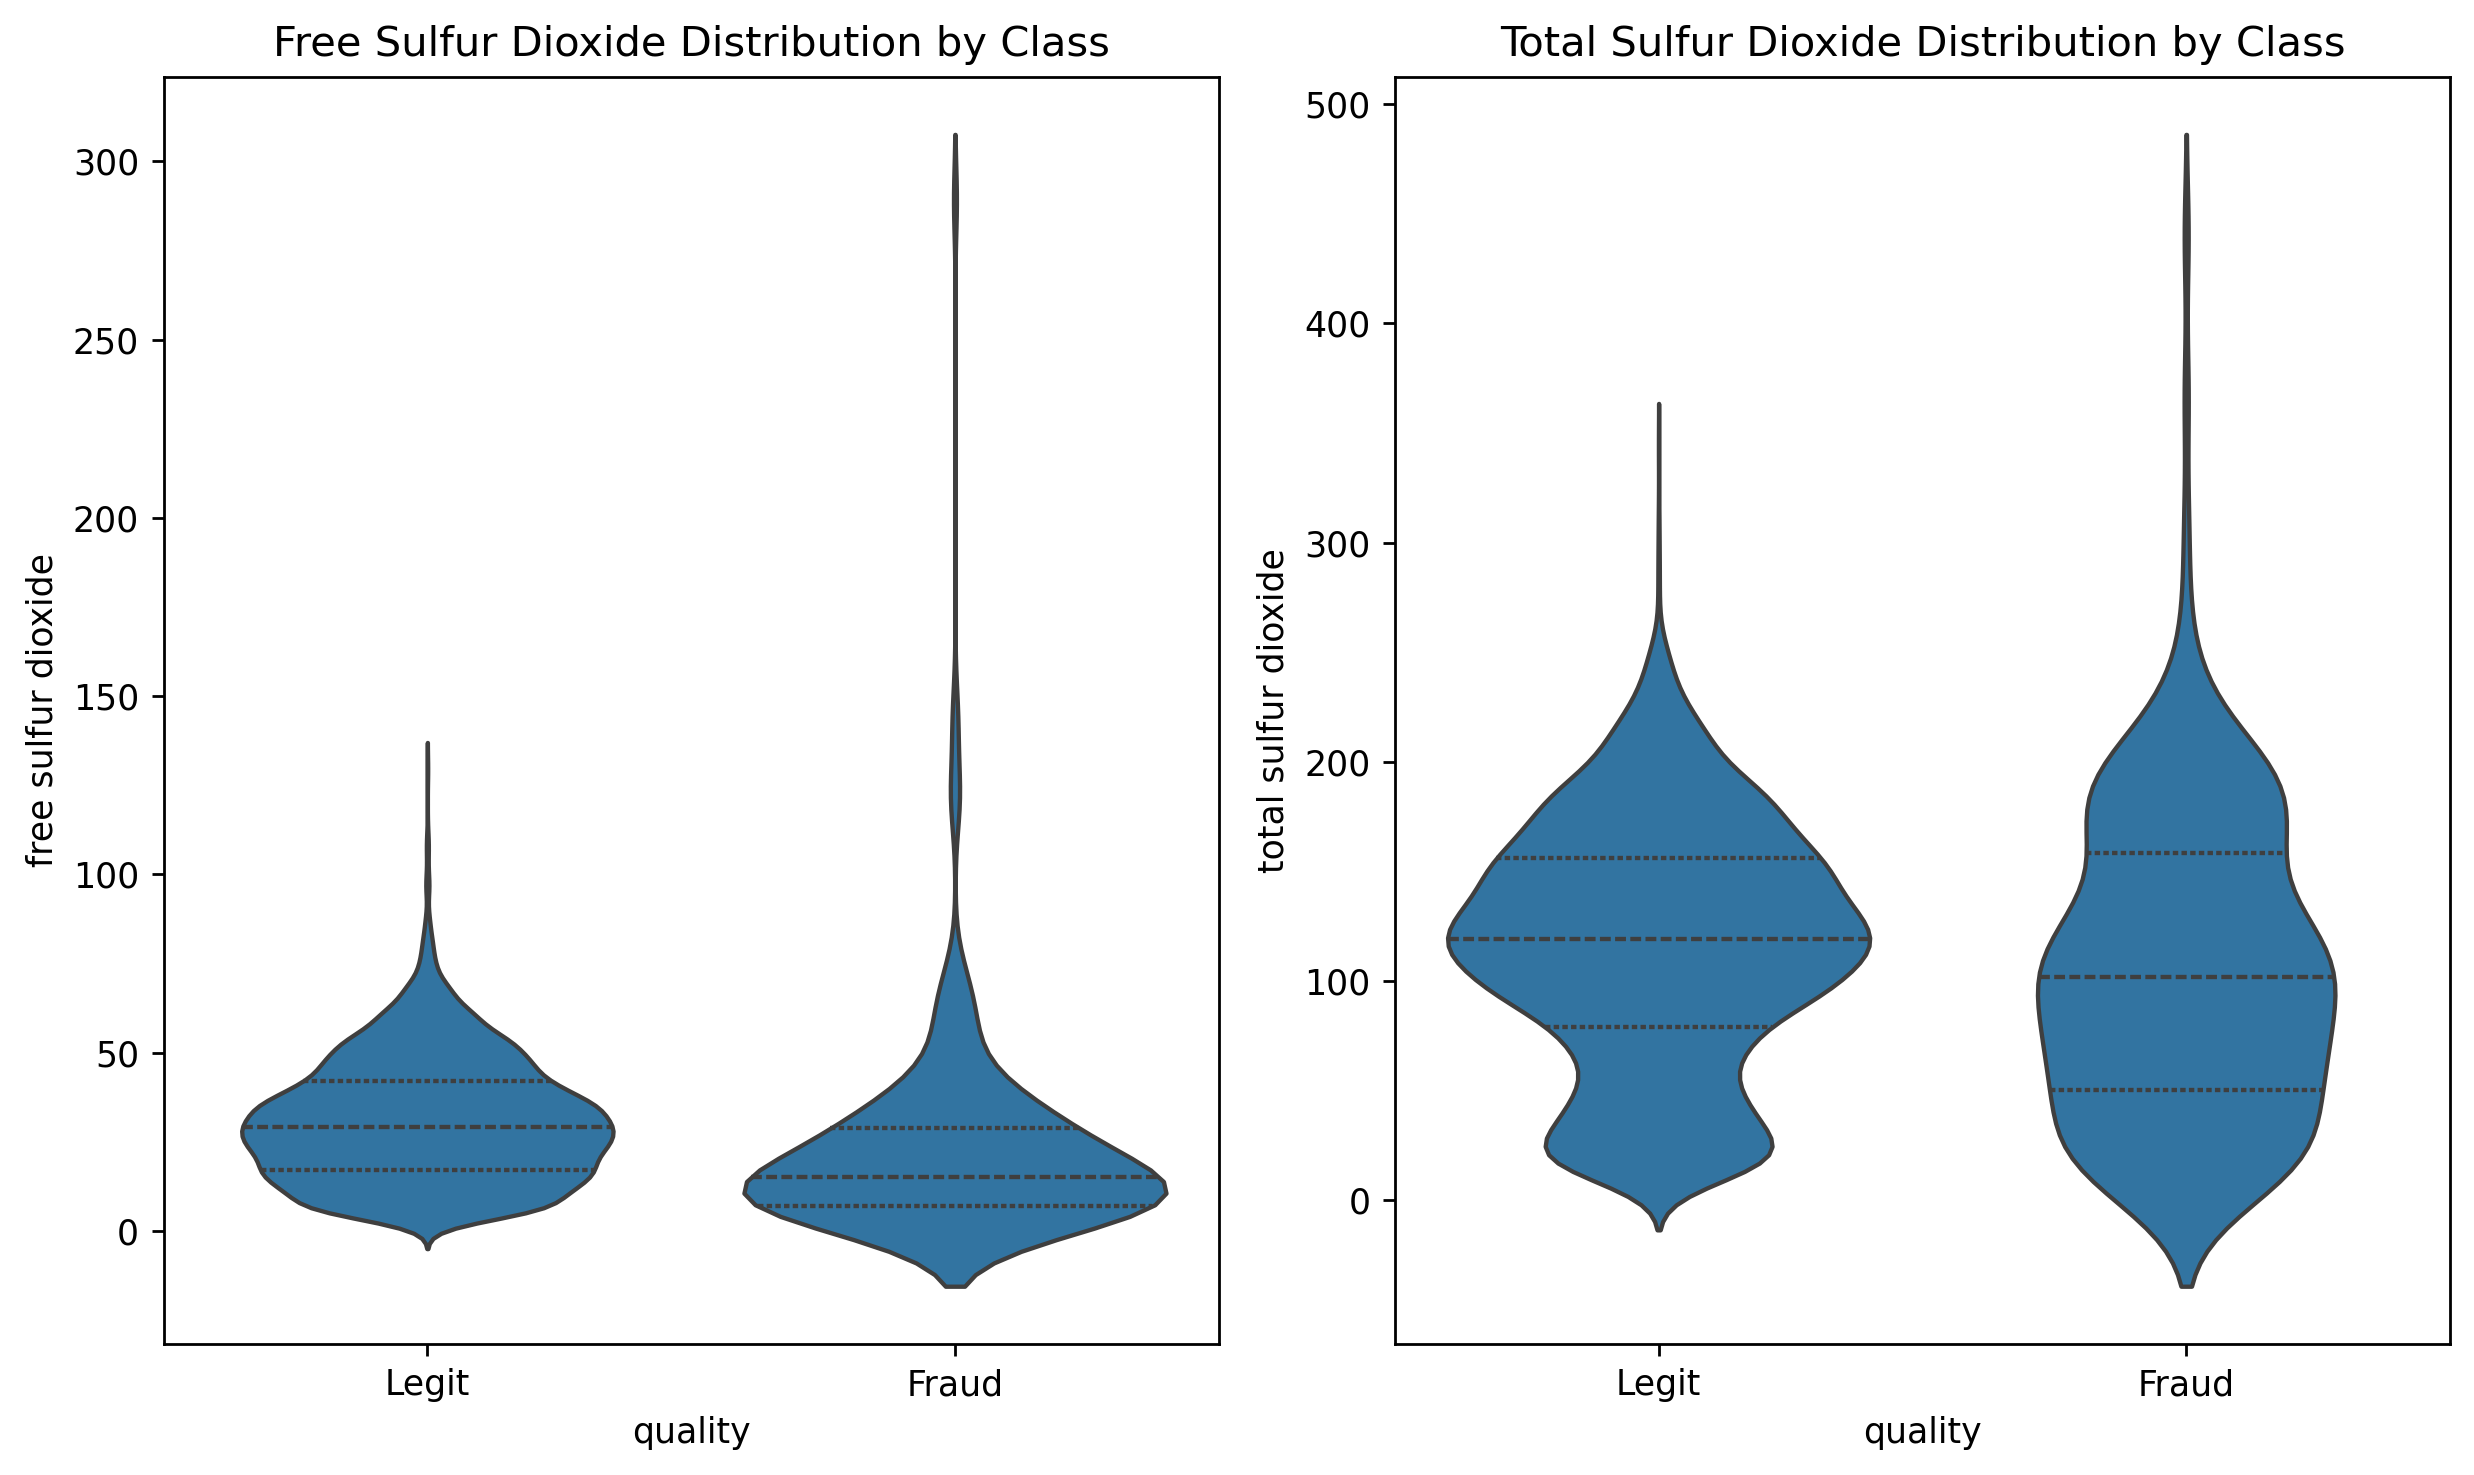

In [15]:
plt.figure(figsize=(10,6),dpi=250)
plt.subplot(1,2,1)
sns.violinplot(x='quality', y='free sulfur dioxide', data=df, inner='quartile')
plt.title("Free Sulfur Dioxide Distribution by Class")
plt.subplot(1,2,2)
sns.violinplot(x='quality', y='total sulfur dioxide', data=df, inner='quartile')
plt.title("Total Sulfur Dioxide Distribution by Class")
plt.tight_layout()
plt.savefig("visualizations/wine_fraud_violinplot.png");

### 8. Clustermap of Feature Relationships

Use Seaborn’s `clustermap` to hierarchically cluster and visualize pairwise correlations among all numeric features.  
By rearranging both rows and columns according to similarity, you’ll uncover groups of variables that behave alike—helping you spot redundant features or unexpected associations at a glance.

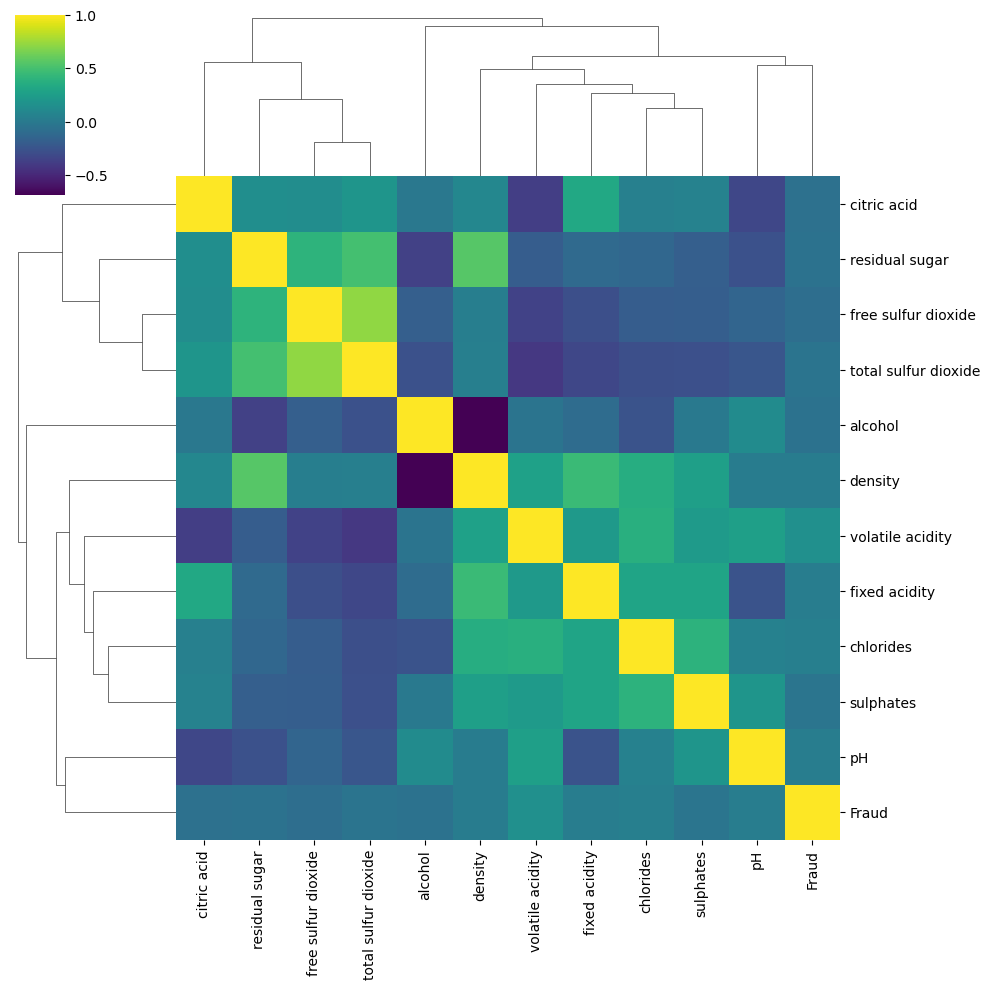

In [16]:
sns.clustermap(df.select_dtypes('number').corr(),cmap='viridis')
plt.savefig("visualizations/wine_fraud_clustermap.png");

### 9. PCA 2-Component Projection  
Projecting the high-dimensional data into 2D via PCA can sometimes reveal class separation or clusters.

In [17]:
features = df.select_dtypes('number').values
pca = PCA(n_components=2)
pc = pca.fit_transform((features - np.mean(features,axis=0)) / np.std(features,axis=0))

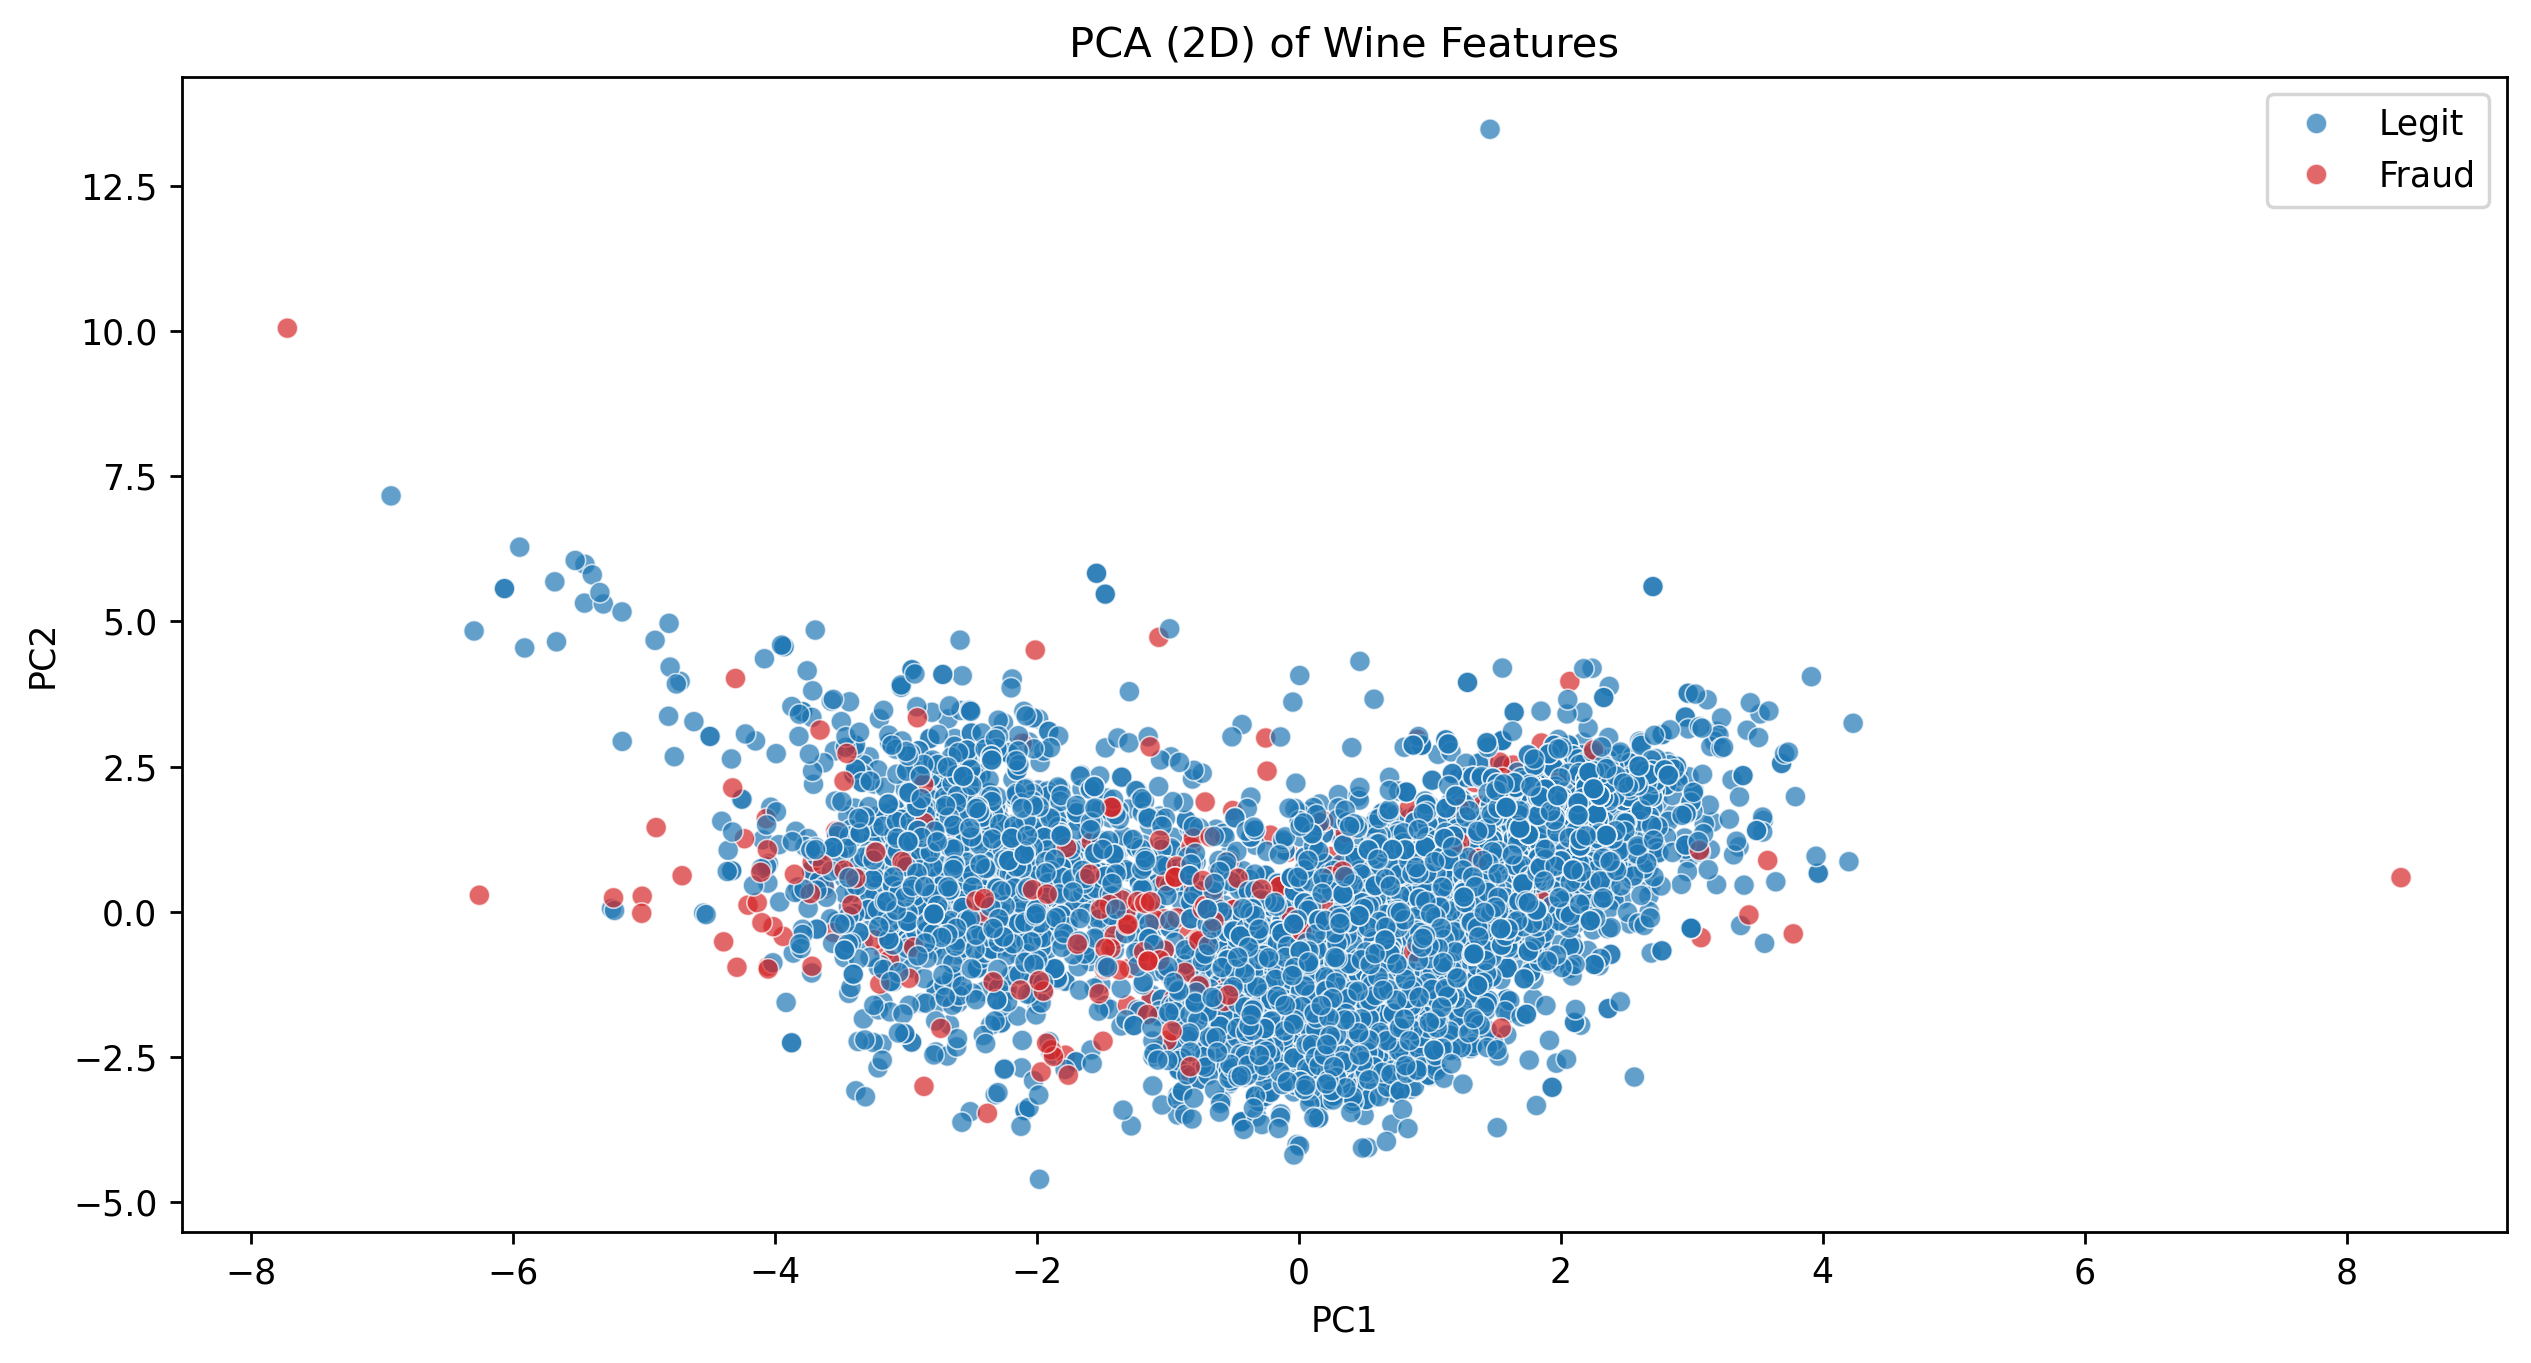

In [18]:
plt.figure(figsize=(12,6),dpi=250)
sns.scatterplot(x=pc[:,0], y=pc[:,1], hue=df.quality, palette=['C0','C3'], alpha=0.7)
plt.title("PCA (2D) of Wine Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig("visualizations/wine_fraud_pca.png")
plt.legend();


## Feature Engineering

After completing our exploratory data analysis, we introduce a dedicated feature engineering phase.  The goal is to transform and combine existing chemical measurements into new predictors that capture subtle patterns of adulteration or aging—patterns that raw inputs alone might miss.  Below is a detailed account of each engineered feature, with motivation, formal definition, and intended interpretation.

---


### 1. Acidity Balance Ratio (`acid_balance_ratio`)

**Rationale**  
Fraudulent wines often have a higher proportion of volatile acidity relative to fixed acidity (ester or spoilage indicators).  

**Observed Difference**  
On average, fraud samples exhibit a 38.4% higher volatile-to-fixed acidity ratio compared to legitimate wines—making this a powerful discriminator.  

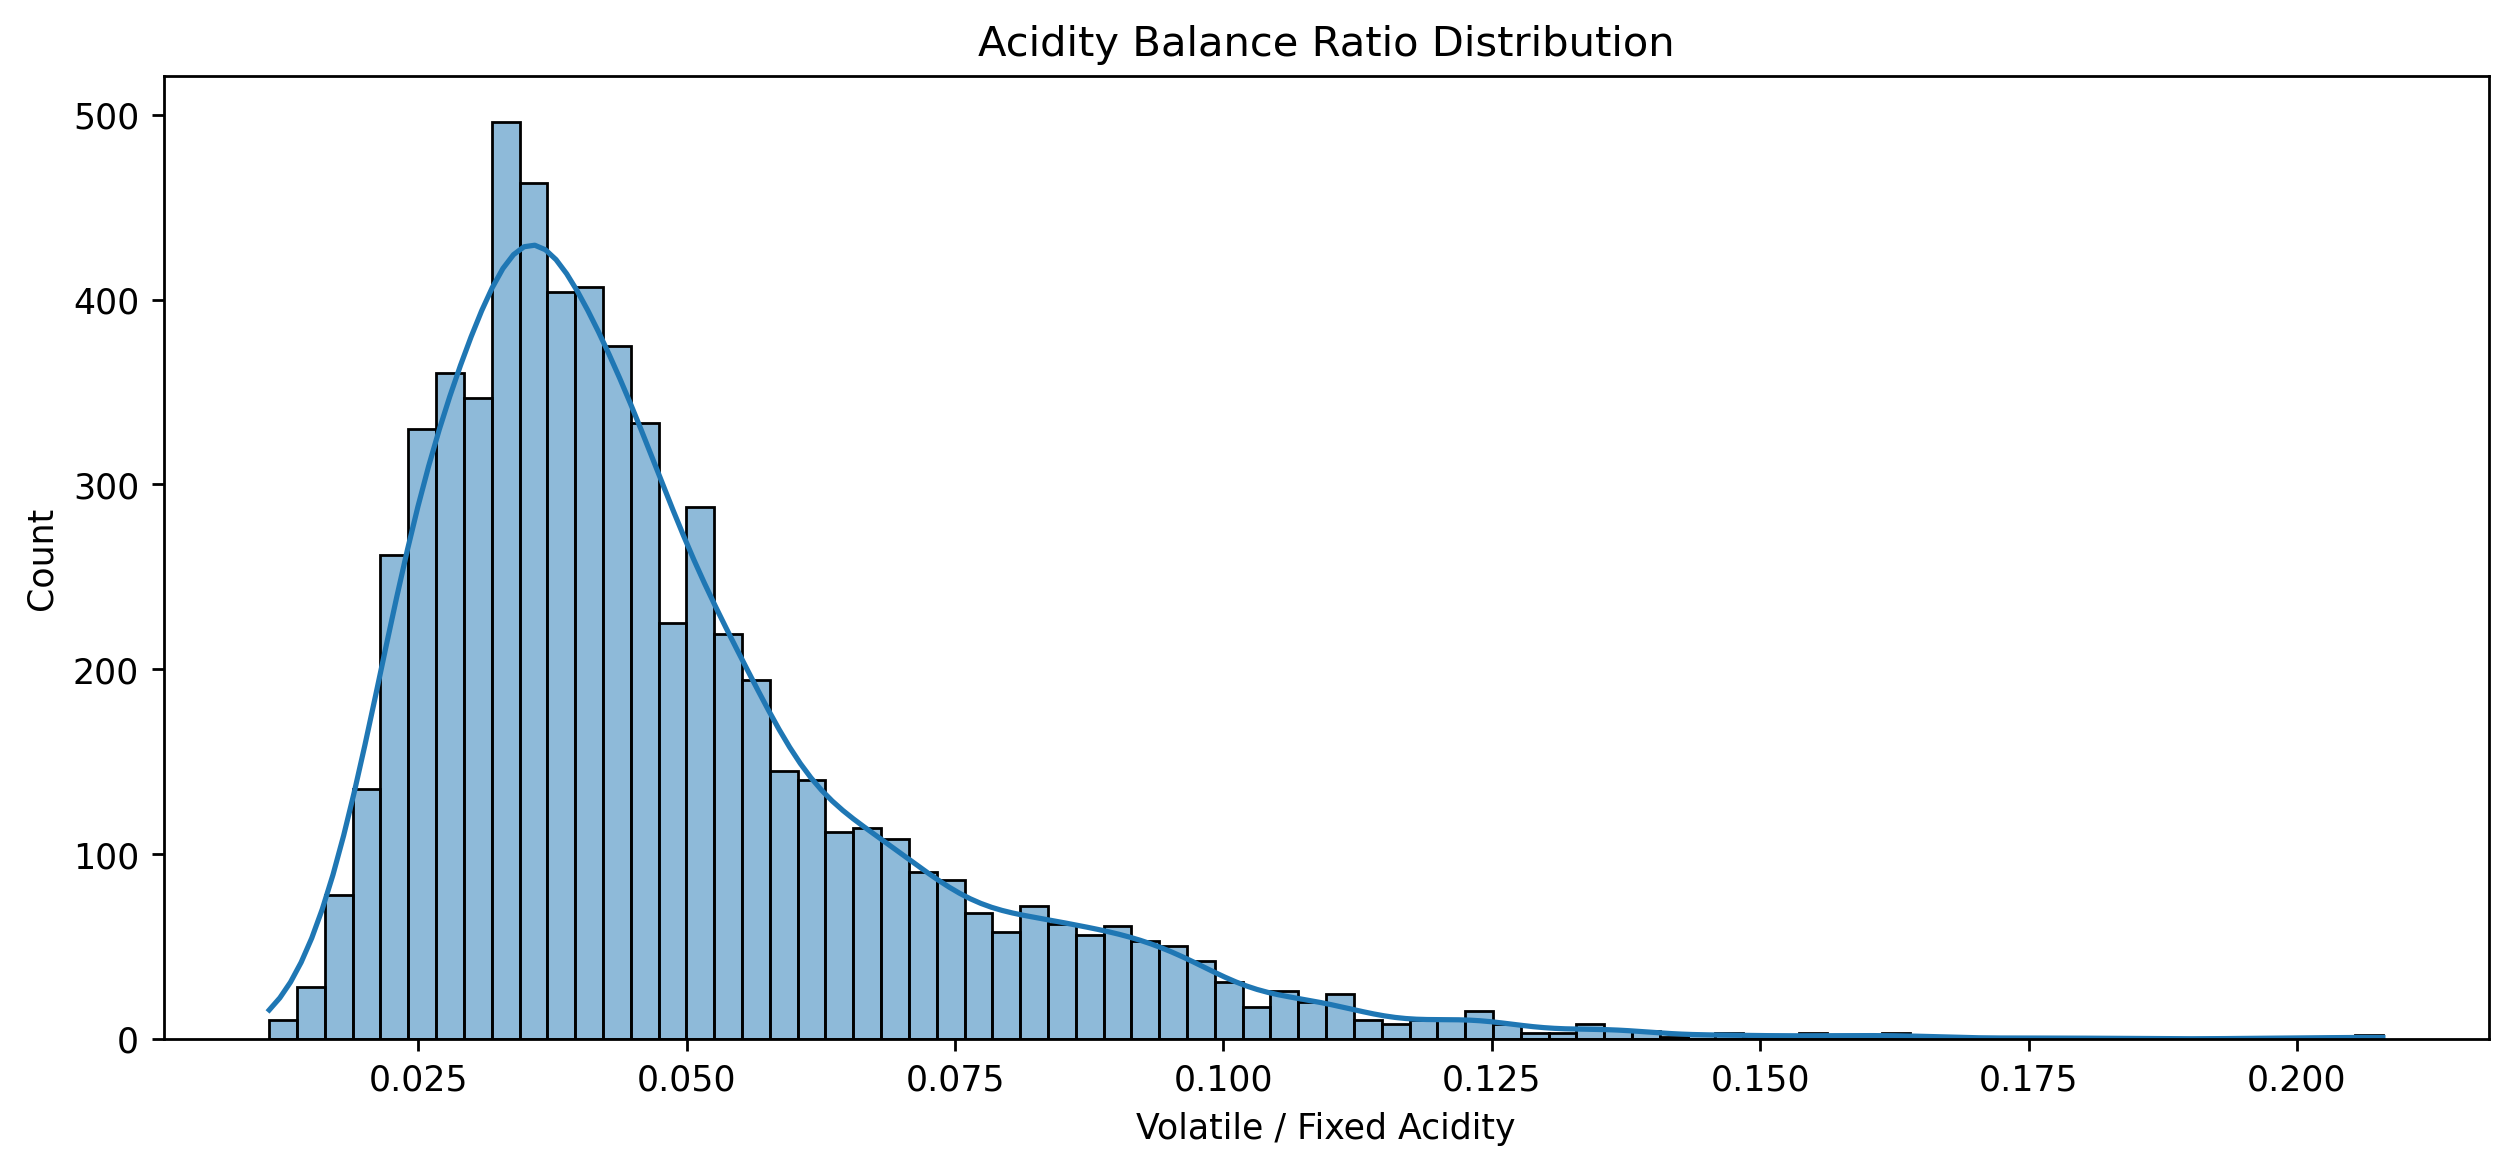

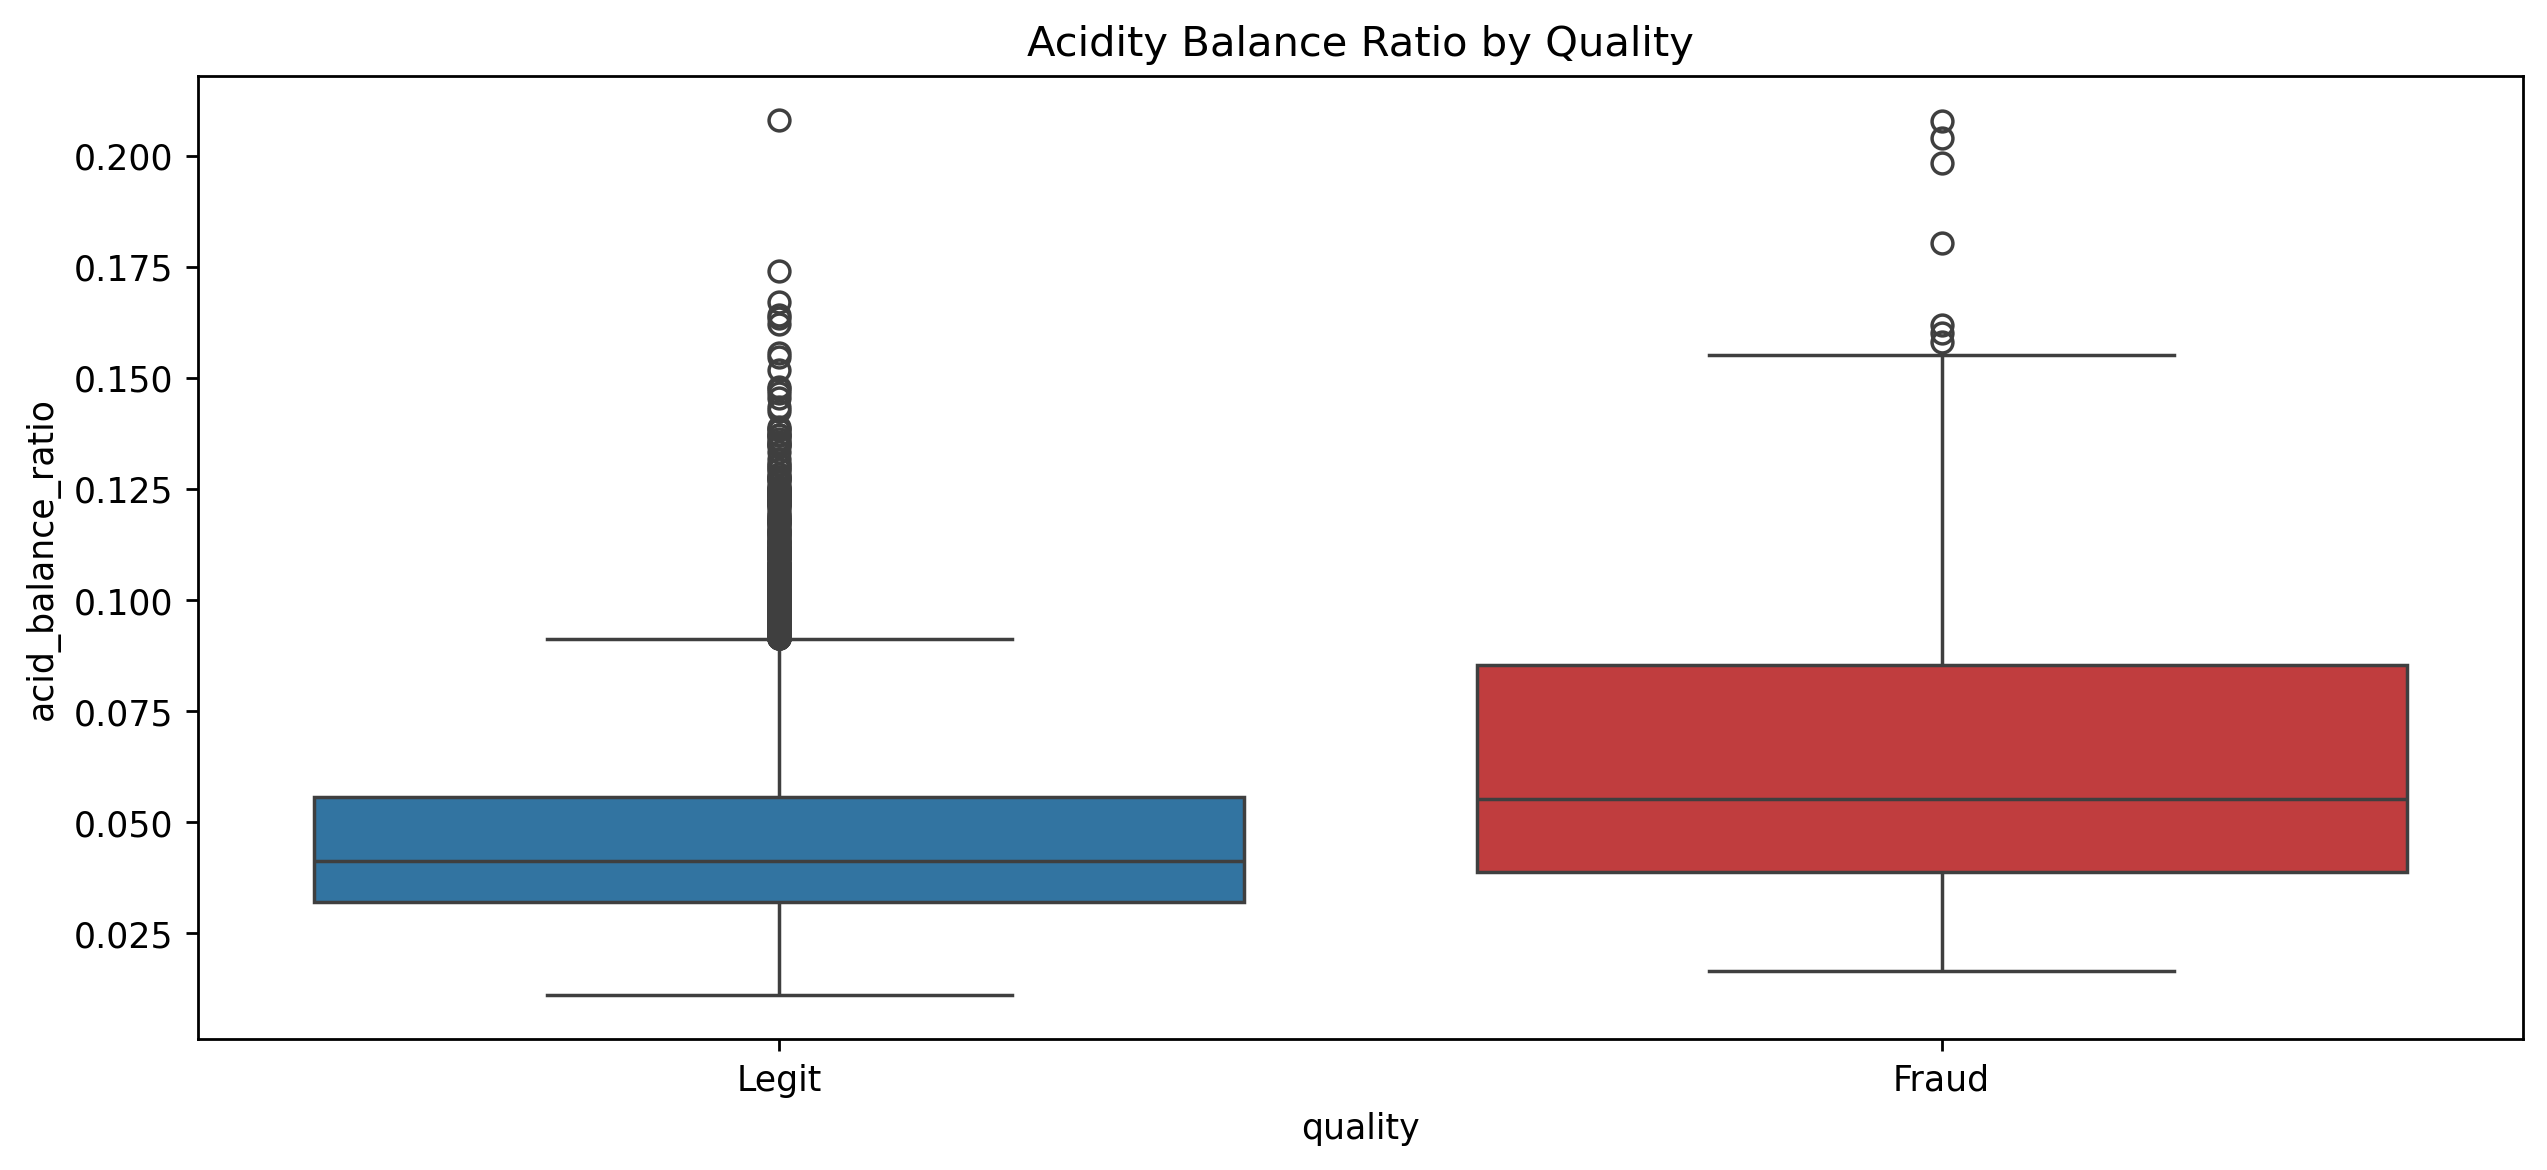

In [19]:
# Acidity Balance Ratio
df['acid_balance_ratio'] = df['volatile acidity'] / df['fixed acidity']

# Overall distribution
plt.figure(figsize=(12,5),dpi=250)
sns.histplot(df['acid_balance_ratio'], kde=True, color='tab:blue')
plt.title("Acidity Balance Ratio Distribution")
plt.xlabel("Volatile / Fixed Acidity")
plt.savefig("visualizations/wine_fraud_acid_balance_ratio_distribution.png")
plt.show()

# By class
plt.figure(figsize=(12,5),dpi=250)
sns.boxplot(x='quality', y='acid_balance_ratio', data=df,hue="quality", palette=['C0','C3'])
plt.title("Acidity Balance Ratio by Quality")
plt.savefig("visualizations/wine_fraud_acid_balance_ratio_by_quality.png")
plt.show()

### 2. Sulfur Preservation Index (`sulfur_preservation_index`)
**Rationale**
A simple free/total ratio can be skewed by extremes in total SO₂. Dividing by the square root of total SO₂ smooths extreme values and more accurately captures preservative efficiency.

**Definition**
sulfur_preservation_index = free_sulfur_dioxide / sqrt(total_sulfur_dioxide)

**Observed Difference**
Legitimate wines score ~24.8% higher on this index than frauds—highlighting real preservation vs. artificial boosting.

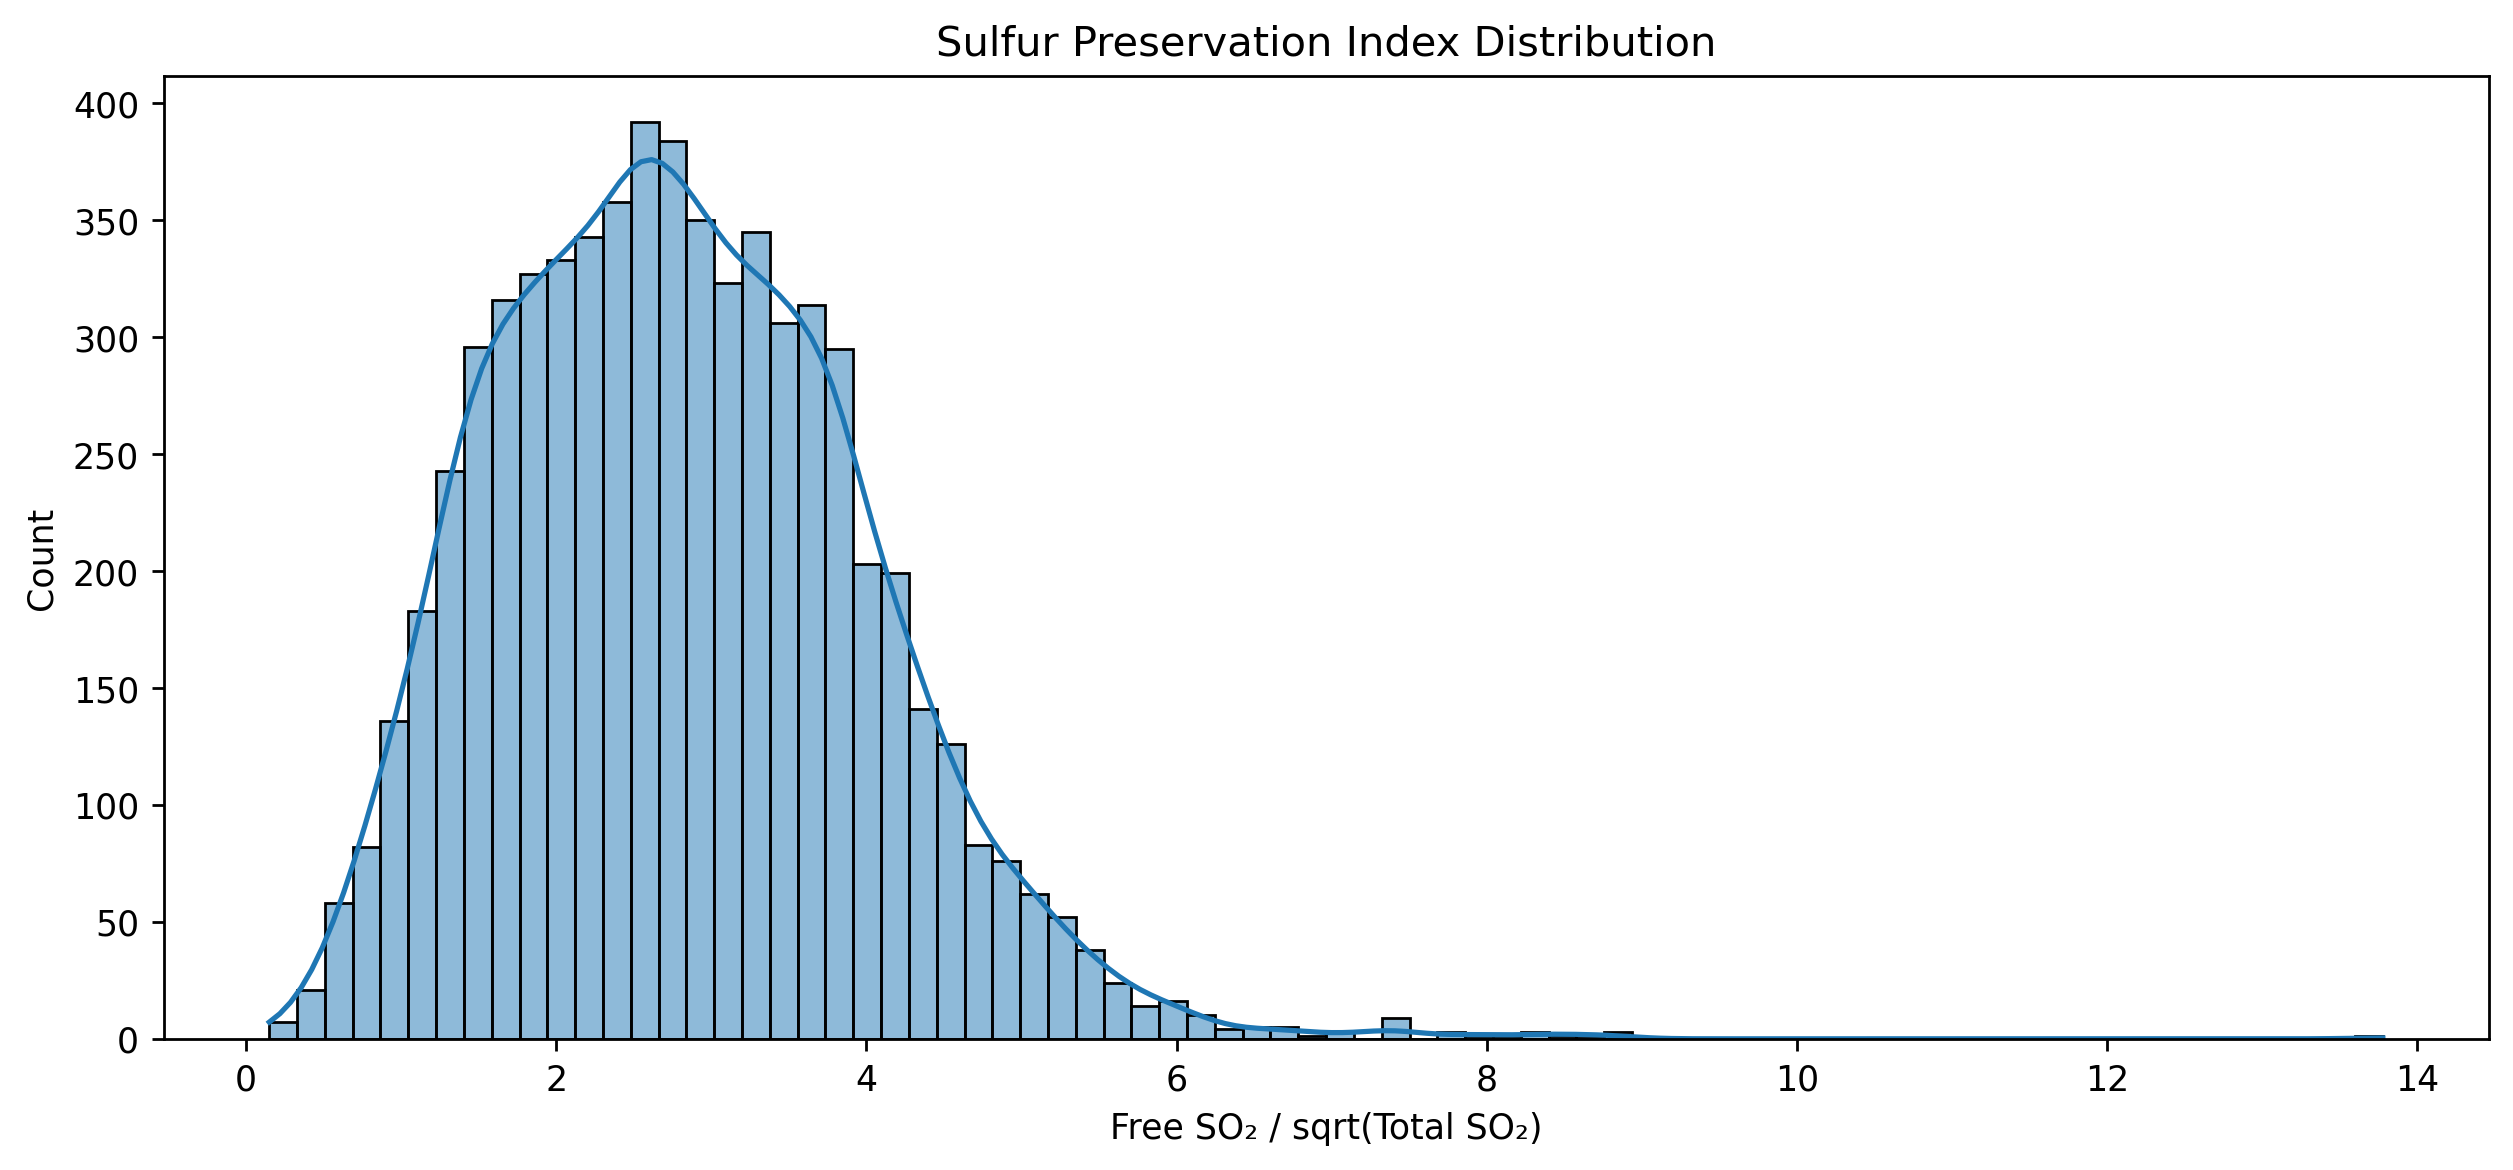

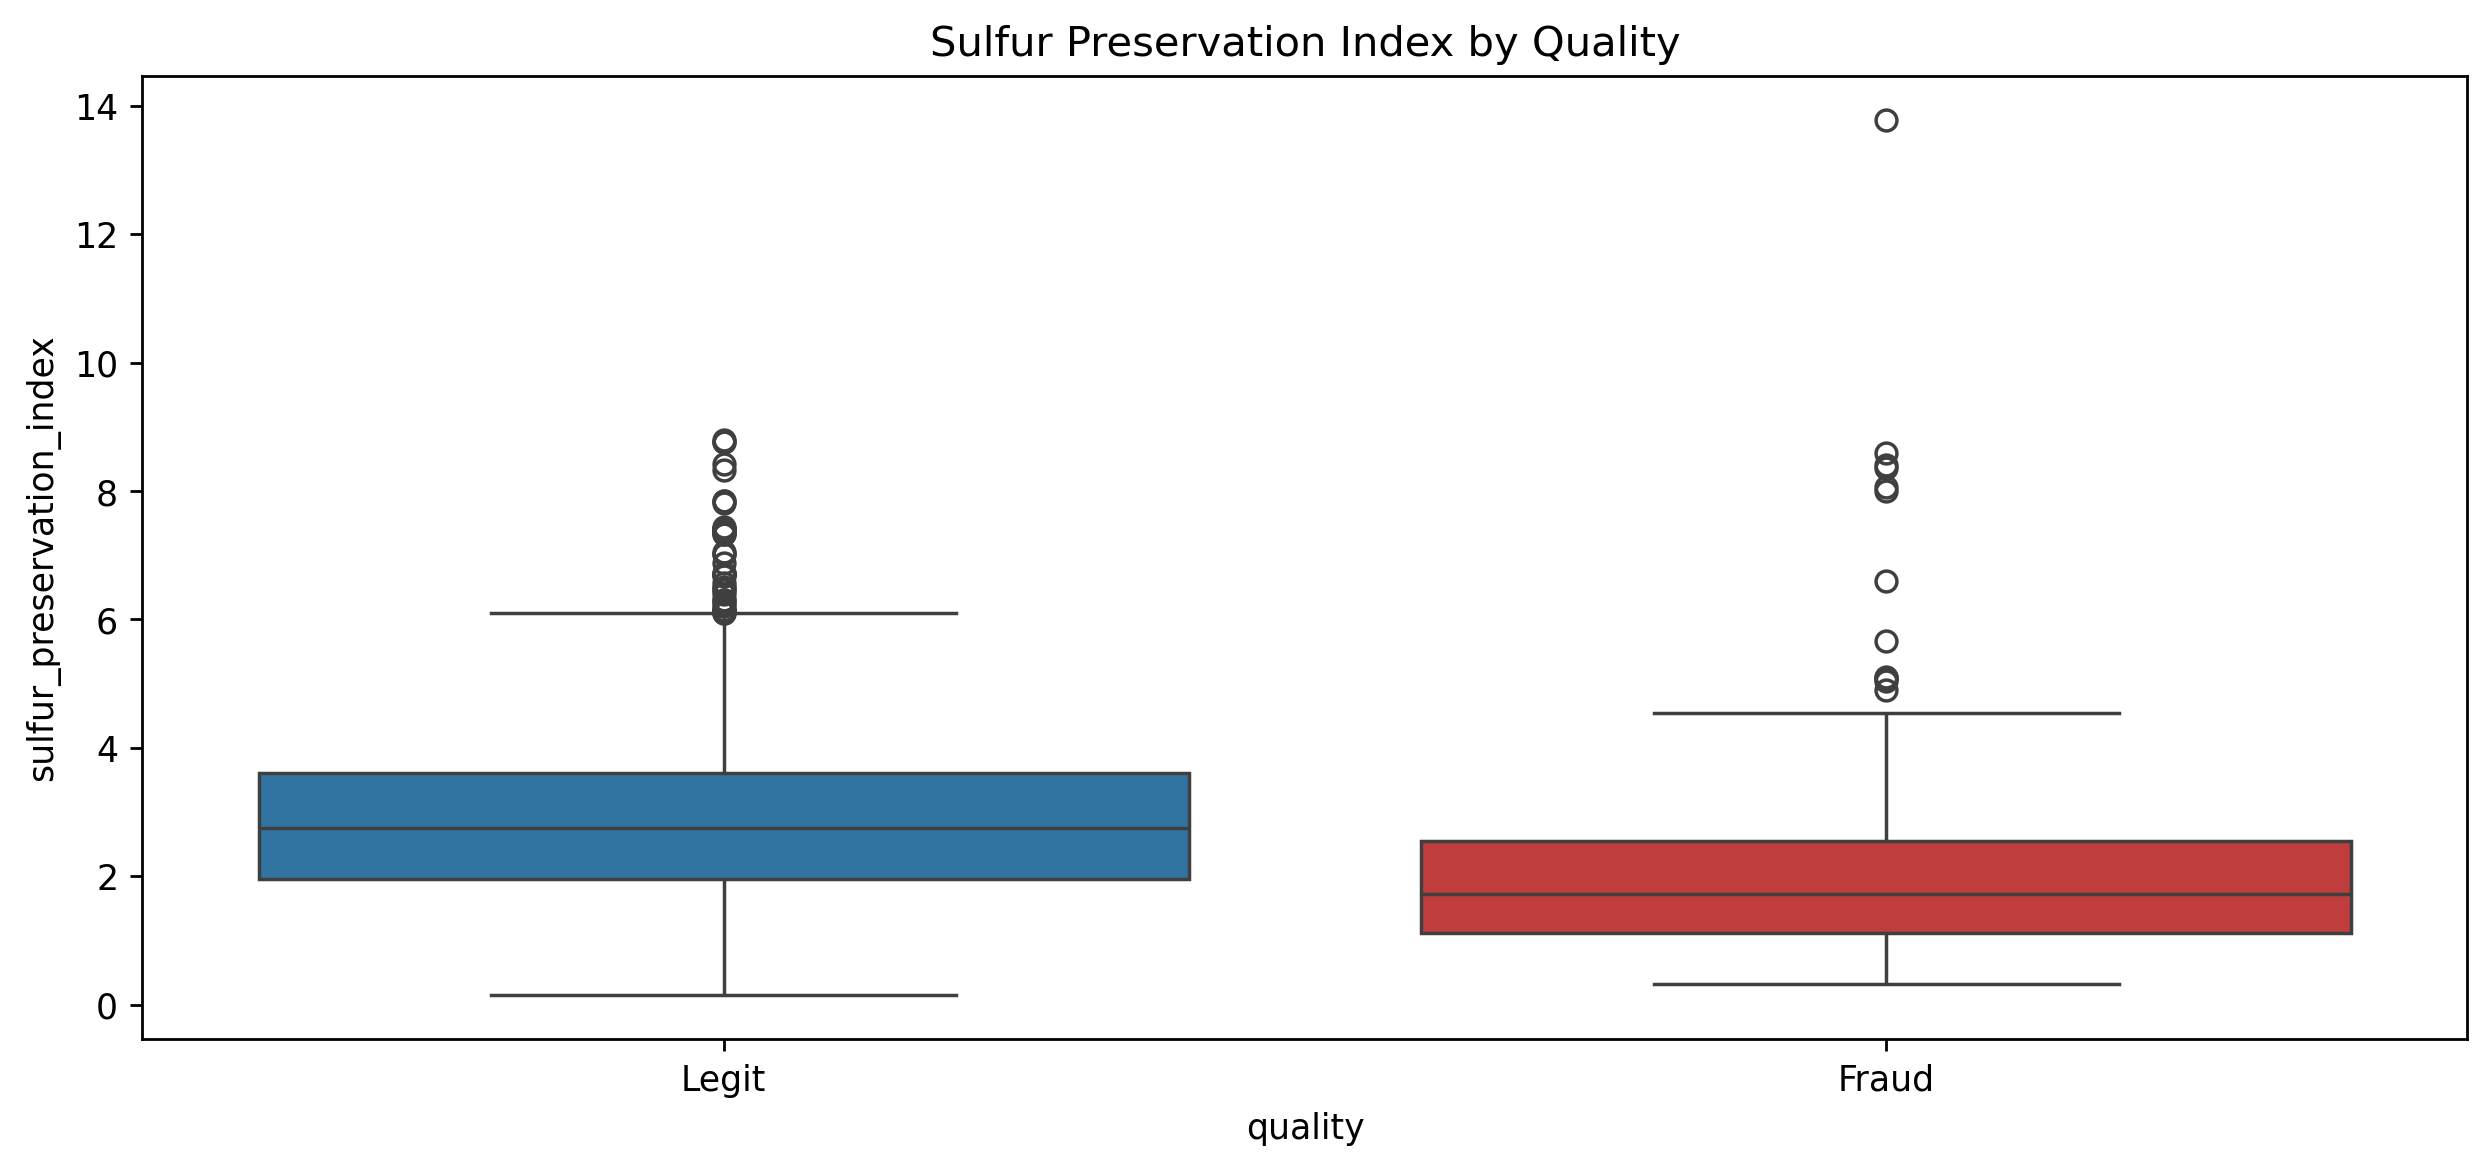

In [20]:
# 2. Sulfur Preservation Index
df['sulfur_preservation_index'] = df['free sulfur dioxide'] / np.sqrt(df['total sulfur dioxide'])

# Overall distribution
plt.figure(figsize=(12,5),dpi=250)
sns.histplot(df['sulfur_preservation_index'], kde=True, color='tab:blue')
plt.title("Sulfur Preservation Index Distribution")
plt.xlabel("Free SO₂ / sqrt(Total SO₂)")
plt.savefig("visualizations/wine_fraud_sulfur_preservation_index_distribution.png")


# By class
plt.figure(figsize=(12,5),dpi=250)
sns.boxplot(x='quality', y='sulfur_preservation_index', data=df,hue="quality", palette=['C0','C3'])
plt.title("Sulfur Preservation Index by Quality")
plt.savefig("visualizations/wine_fraud_sulfur_preservation_index_by_quality.png")


### 3 pH–Volatile Acidity Interaction (`ph_volatile_interaction`)
**Rationale**
Volatile acidity shows the largest percent difference between classes and pH modulates acidity perception. Their product magnifies class-specific signals.

**Definition**
ph_volatile_interaction = pH × volatile_acidity
volatile_acidity

**Observed Difference**
Multiplying by pH amplifies the ~38.9% base difference in volatile acidity, improving separation.

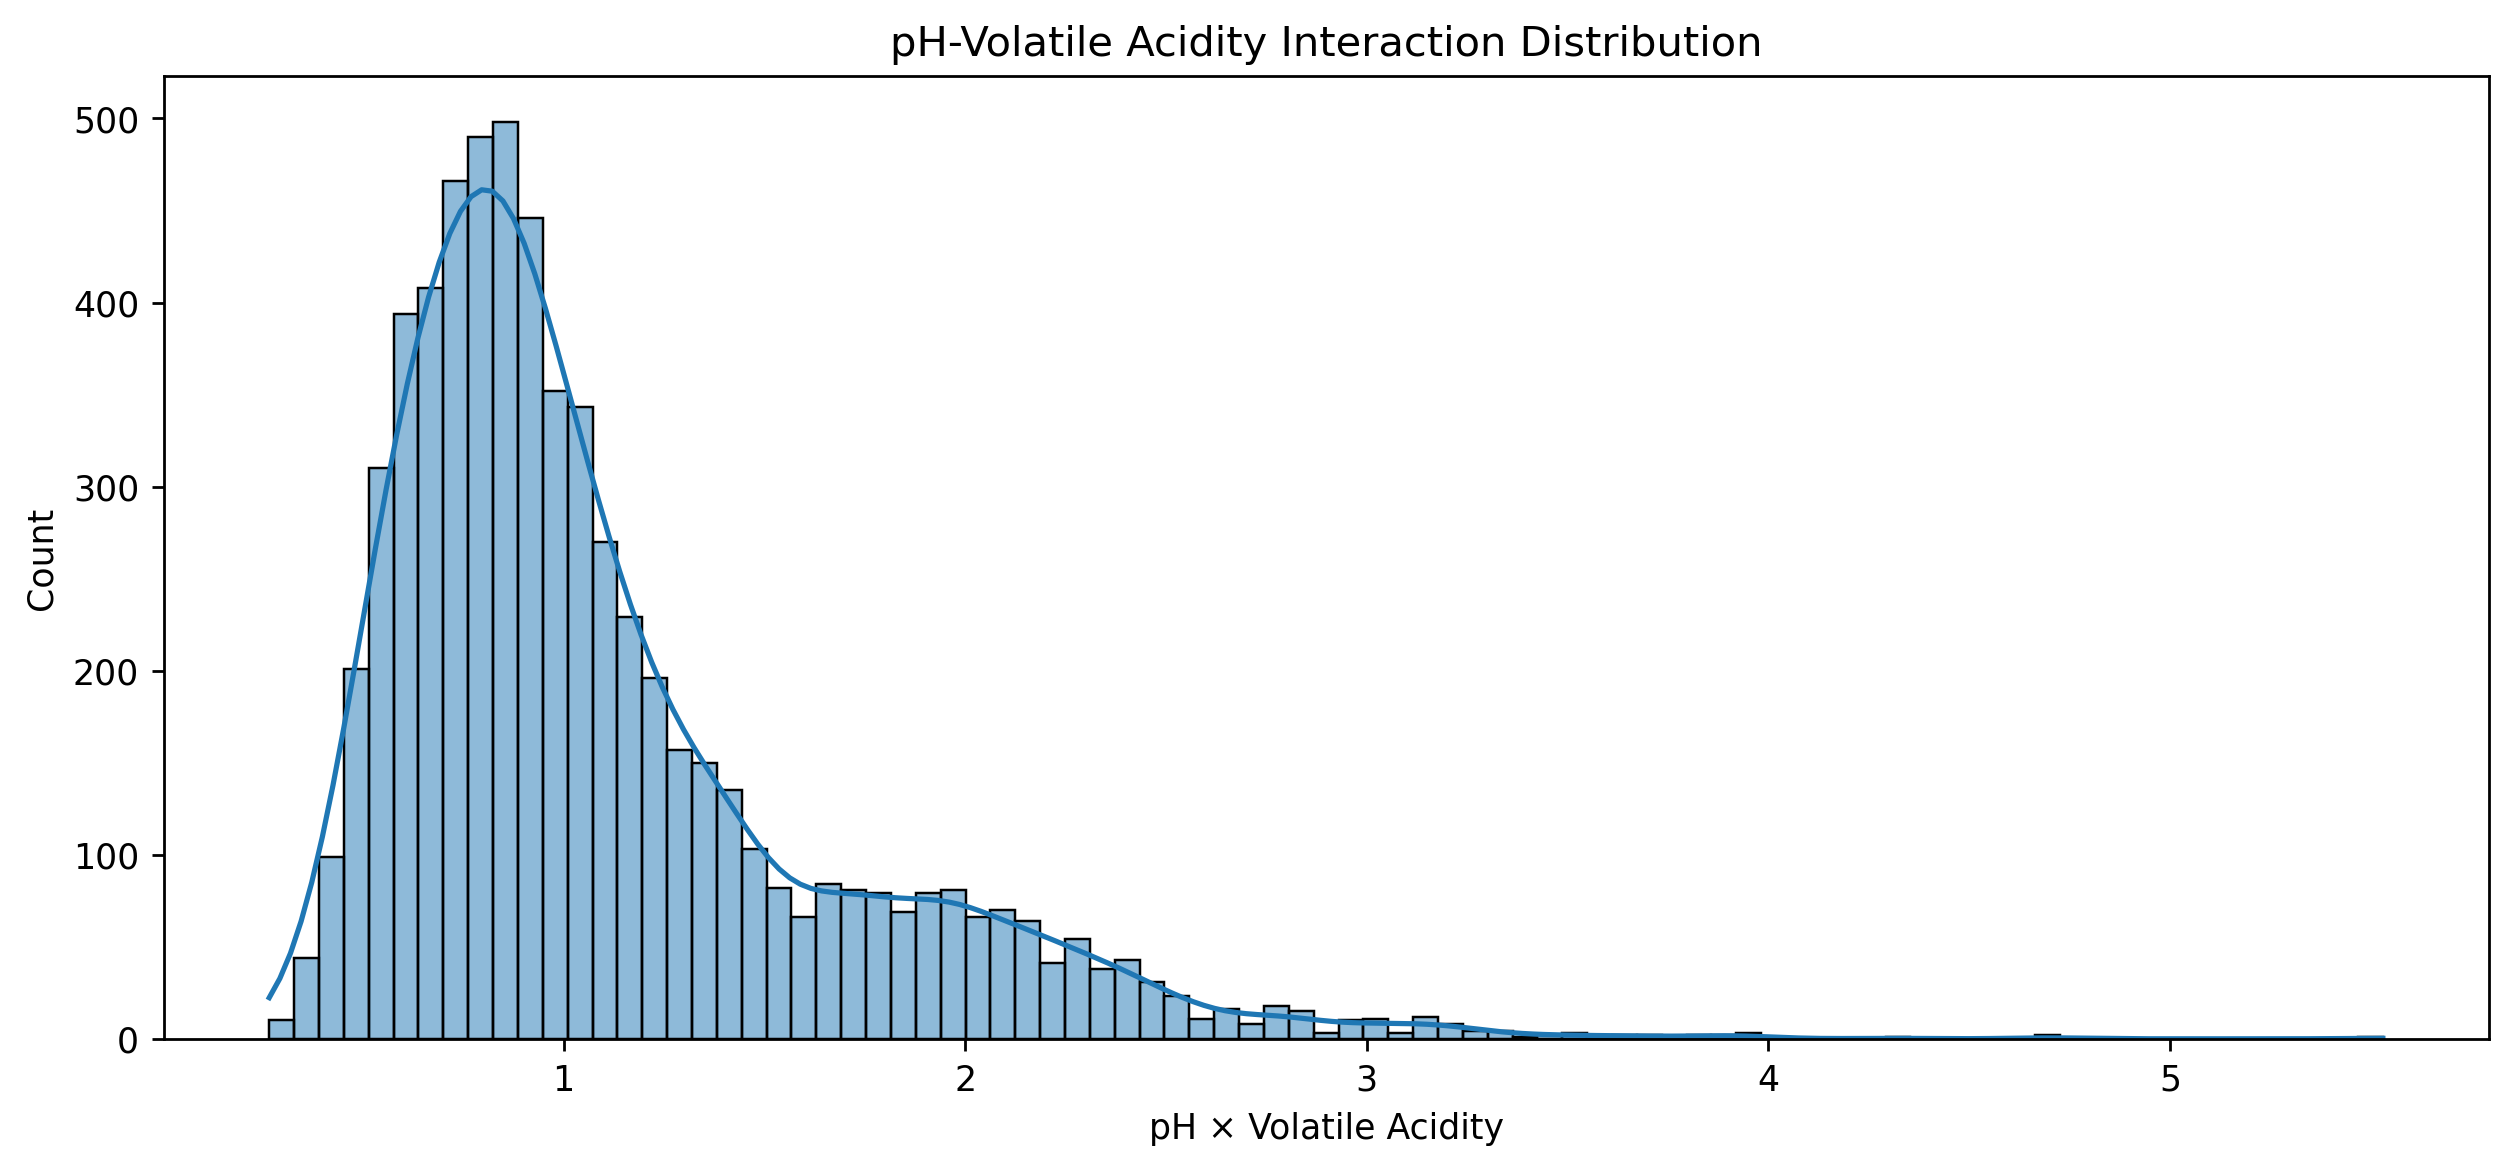

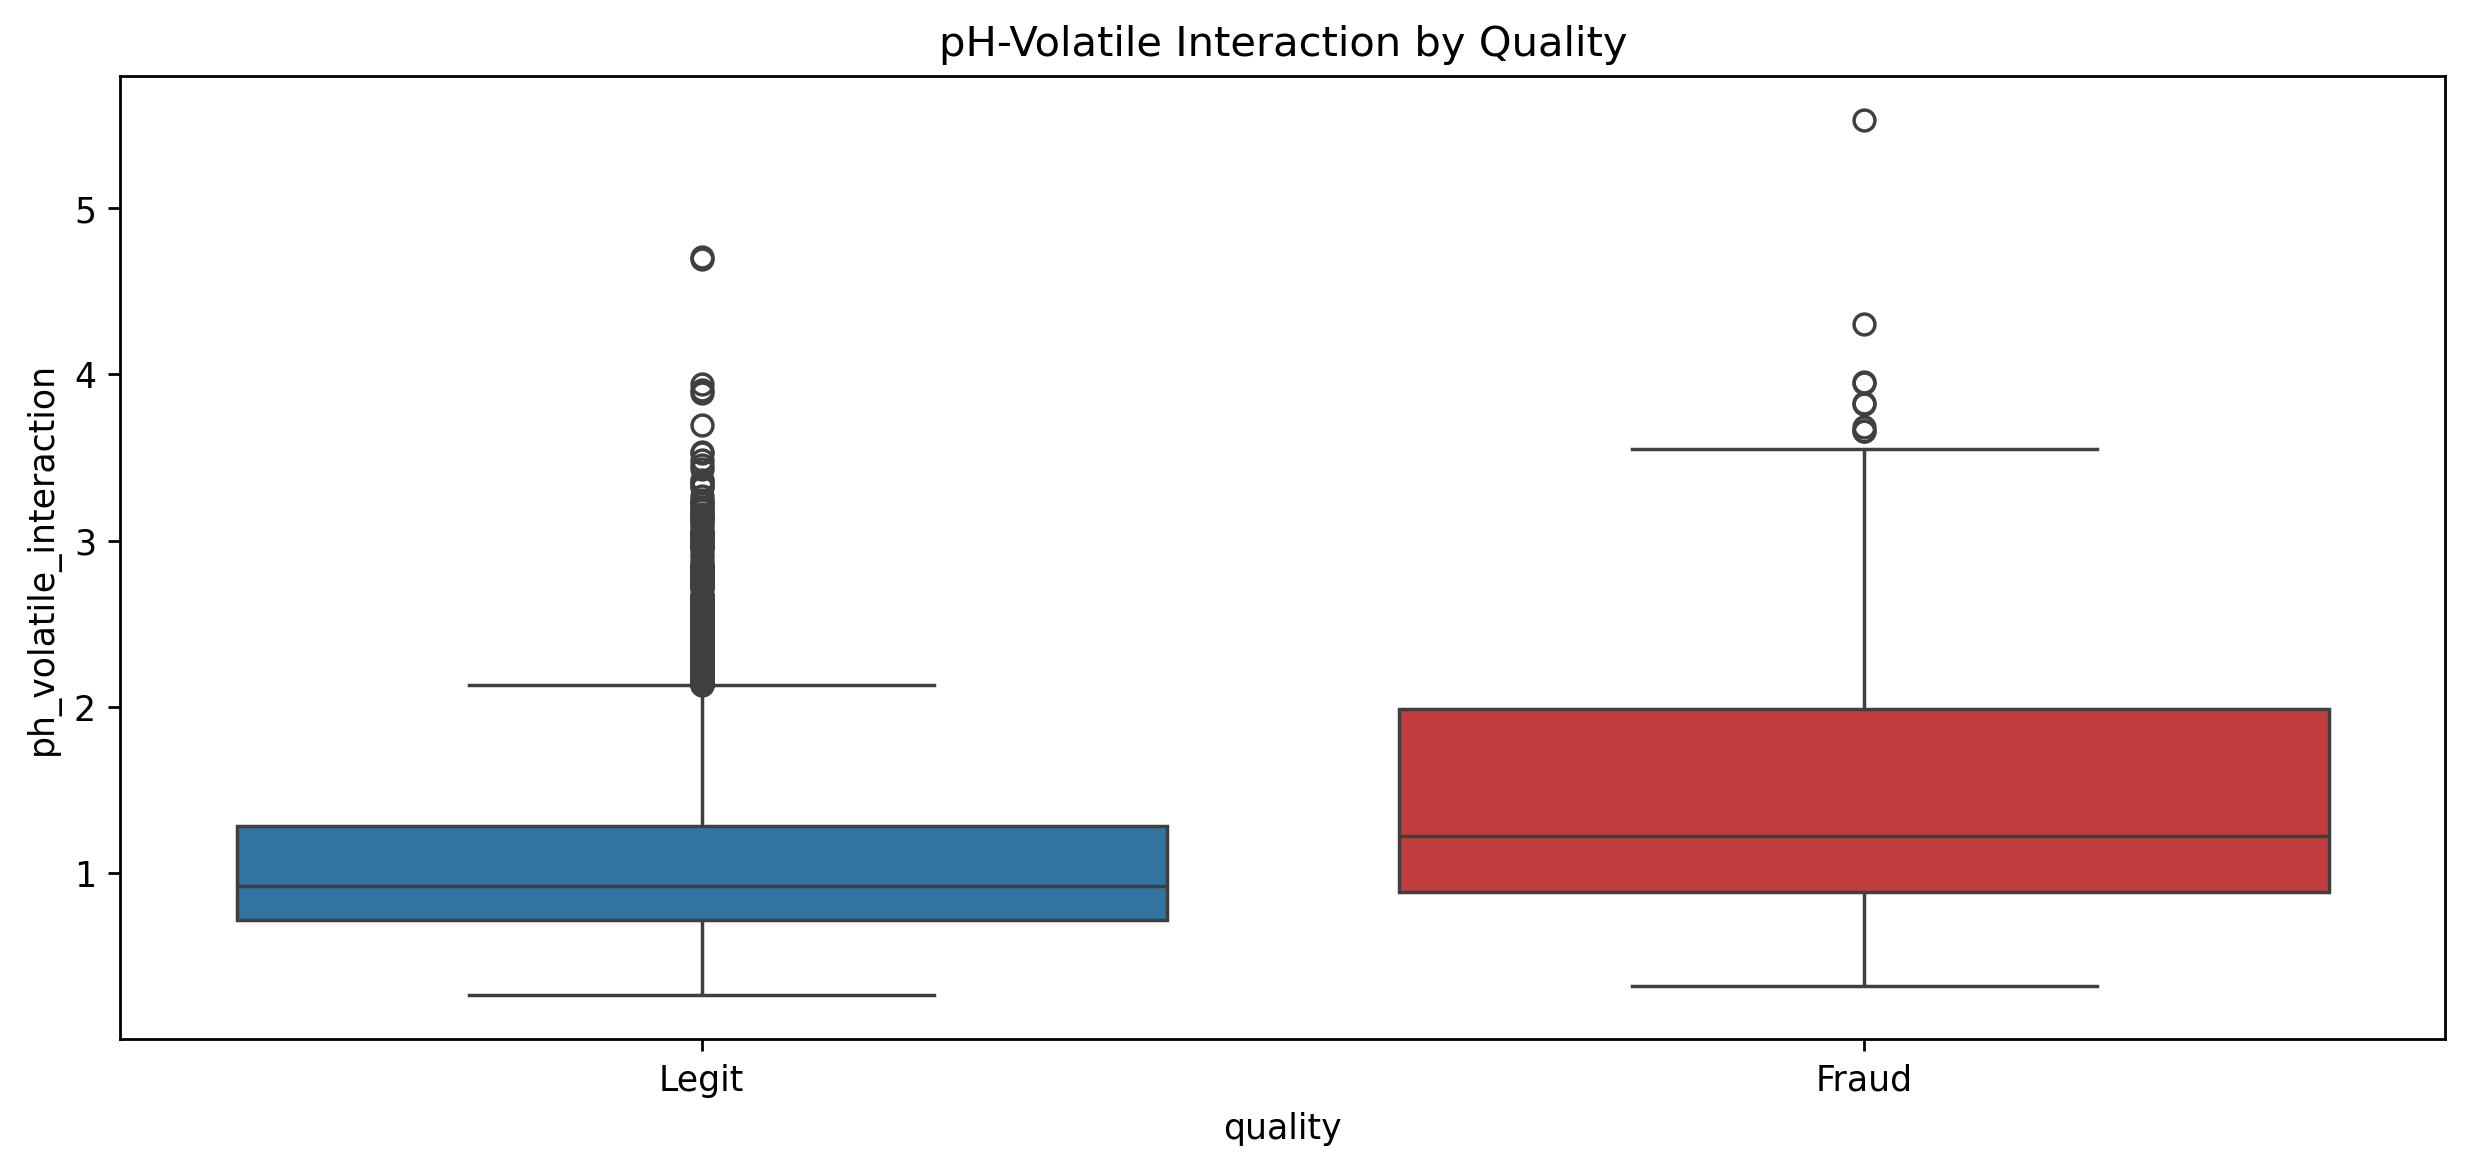

In [21]:
# 3. pH-Volatile Acidity Interaction
df['ph_volatile_interaction'] = df['pH'] * df['volatile acidity']

# Overall distribution
plt.figure(figsize=(12,5),dpi=250)
sns.histplot(df['ph_volatile_interaction'], kde=True, color='tab:blue')
plt.title("pH-Volatile Acidity Interaction Distribution")
plt.xlabel("pH × Volatile Acidity")
plt.savefig("visualizations/wine_fraud_ph_volatile_interaction_distribution.png")

# By class
plt.figure(figsize=(12,5),dpi=250)
sns.boxplot(x='quality', y='ph_volatile_interaction', data=df,hue="quality", palette=['C0','C3'])
plt.title("pH-Volatile Interaction by Quality")
plt.savefig("visualizations/wine_fraud_ph_volatile_interaction_by_quality.png")
plt.show()

### 4. Low Sulfur Indicator (`low_sulfur_indicator`)
**Rationale**
Free SO₂ below 30 ppm is rare in legitimate wines but common in fraud. A simple binary flag captures this risk zone.

**Definition**
low_sulfur_indicator = 1 if free_sulfur_dioxide < 30 else 0

**Observed Concentration**
Fraud samples concentrate heavily in the “low sulfur” bin, making this flag highly predictive of manipulation.

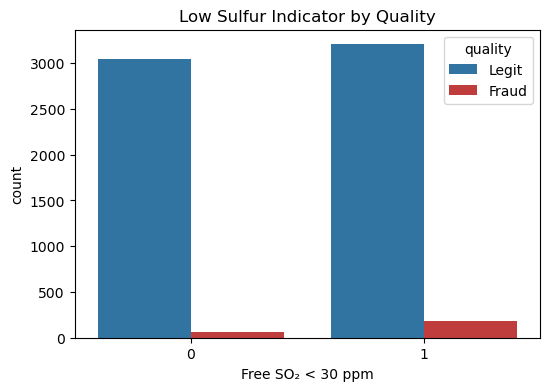

In [22]:
# Sulfur Dioxide Binned Indicator
df['low_sulfur_indicator'] = (df['free sulfur dioxide'] < 30).astype(int)

# Count by flag and class
plt.figure(figsize=(6,4))
sns.countplot(x='low_sulfur_indicator', hue='quality', data=df,
              palette=['C0','C3'])
plt.title("Low Sulfur Indicator by Quality")
plt.xlabel("Free SO₂ < 30 ppm")
plt.show()

### 5. Acidity–Sugar Balance (`acidity_sugar_balance`)
**Rationale**
Fixed and volatile acidity govern tartness, while residual sugar governs sweetness. Balancing the two on a log scale accentuates differences in how acids and sugar co‐vary.

**Definition**
acidity_sugar_balance = (fixed_acidity + volatile_acidity) / log(1 + residual_sugar)

**Observed Difference**
The ratio separates classes by ~17.9%, capturing distinct sweet–tart profiles in fraud vs. legit wines.

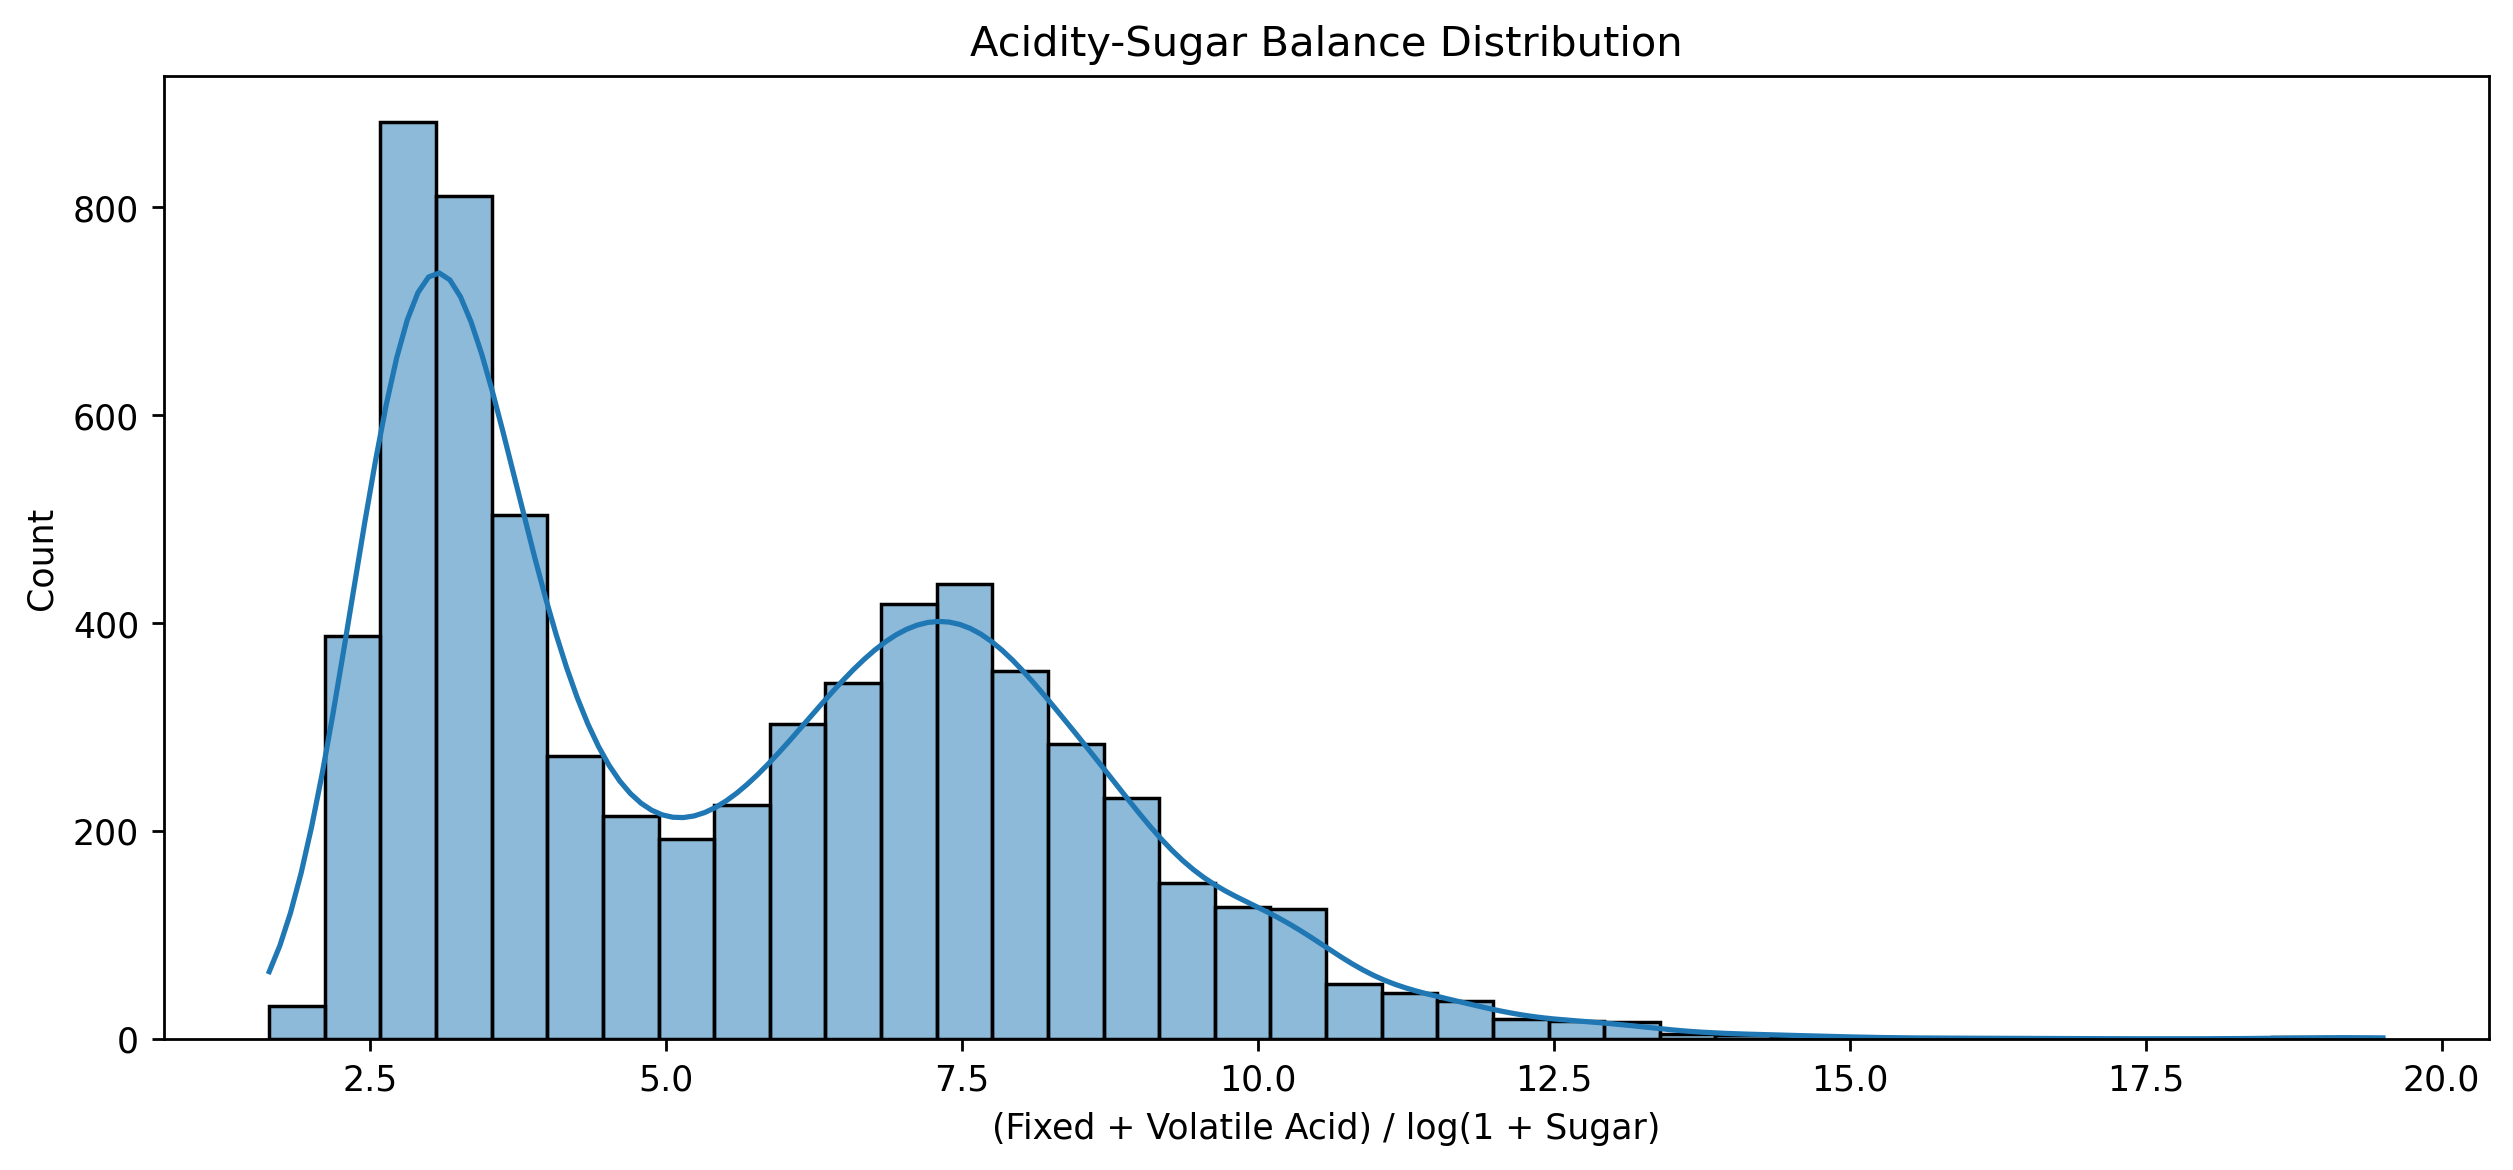

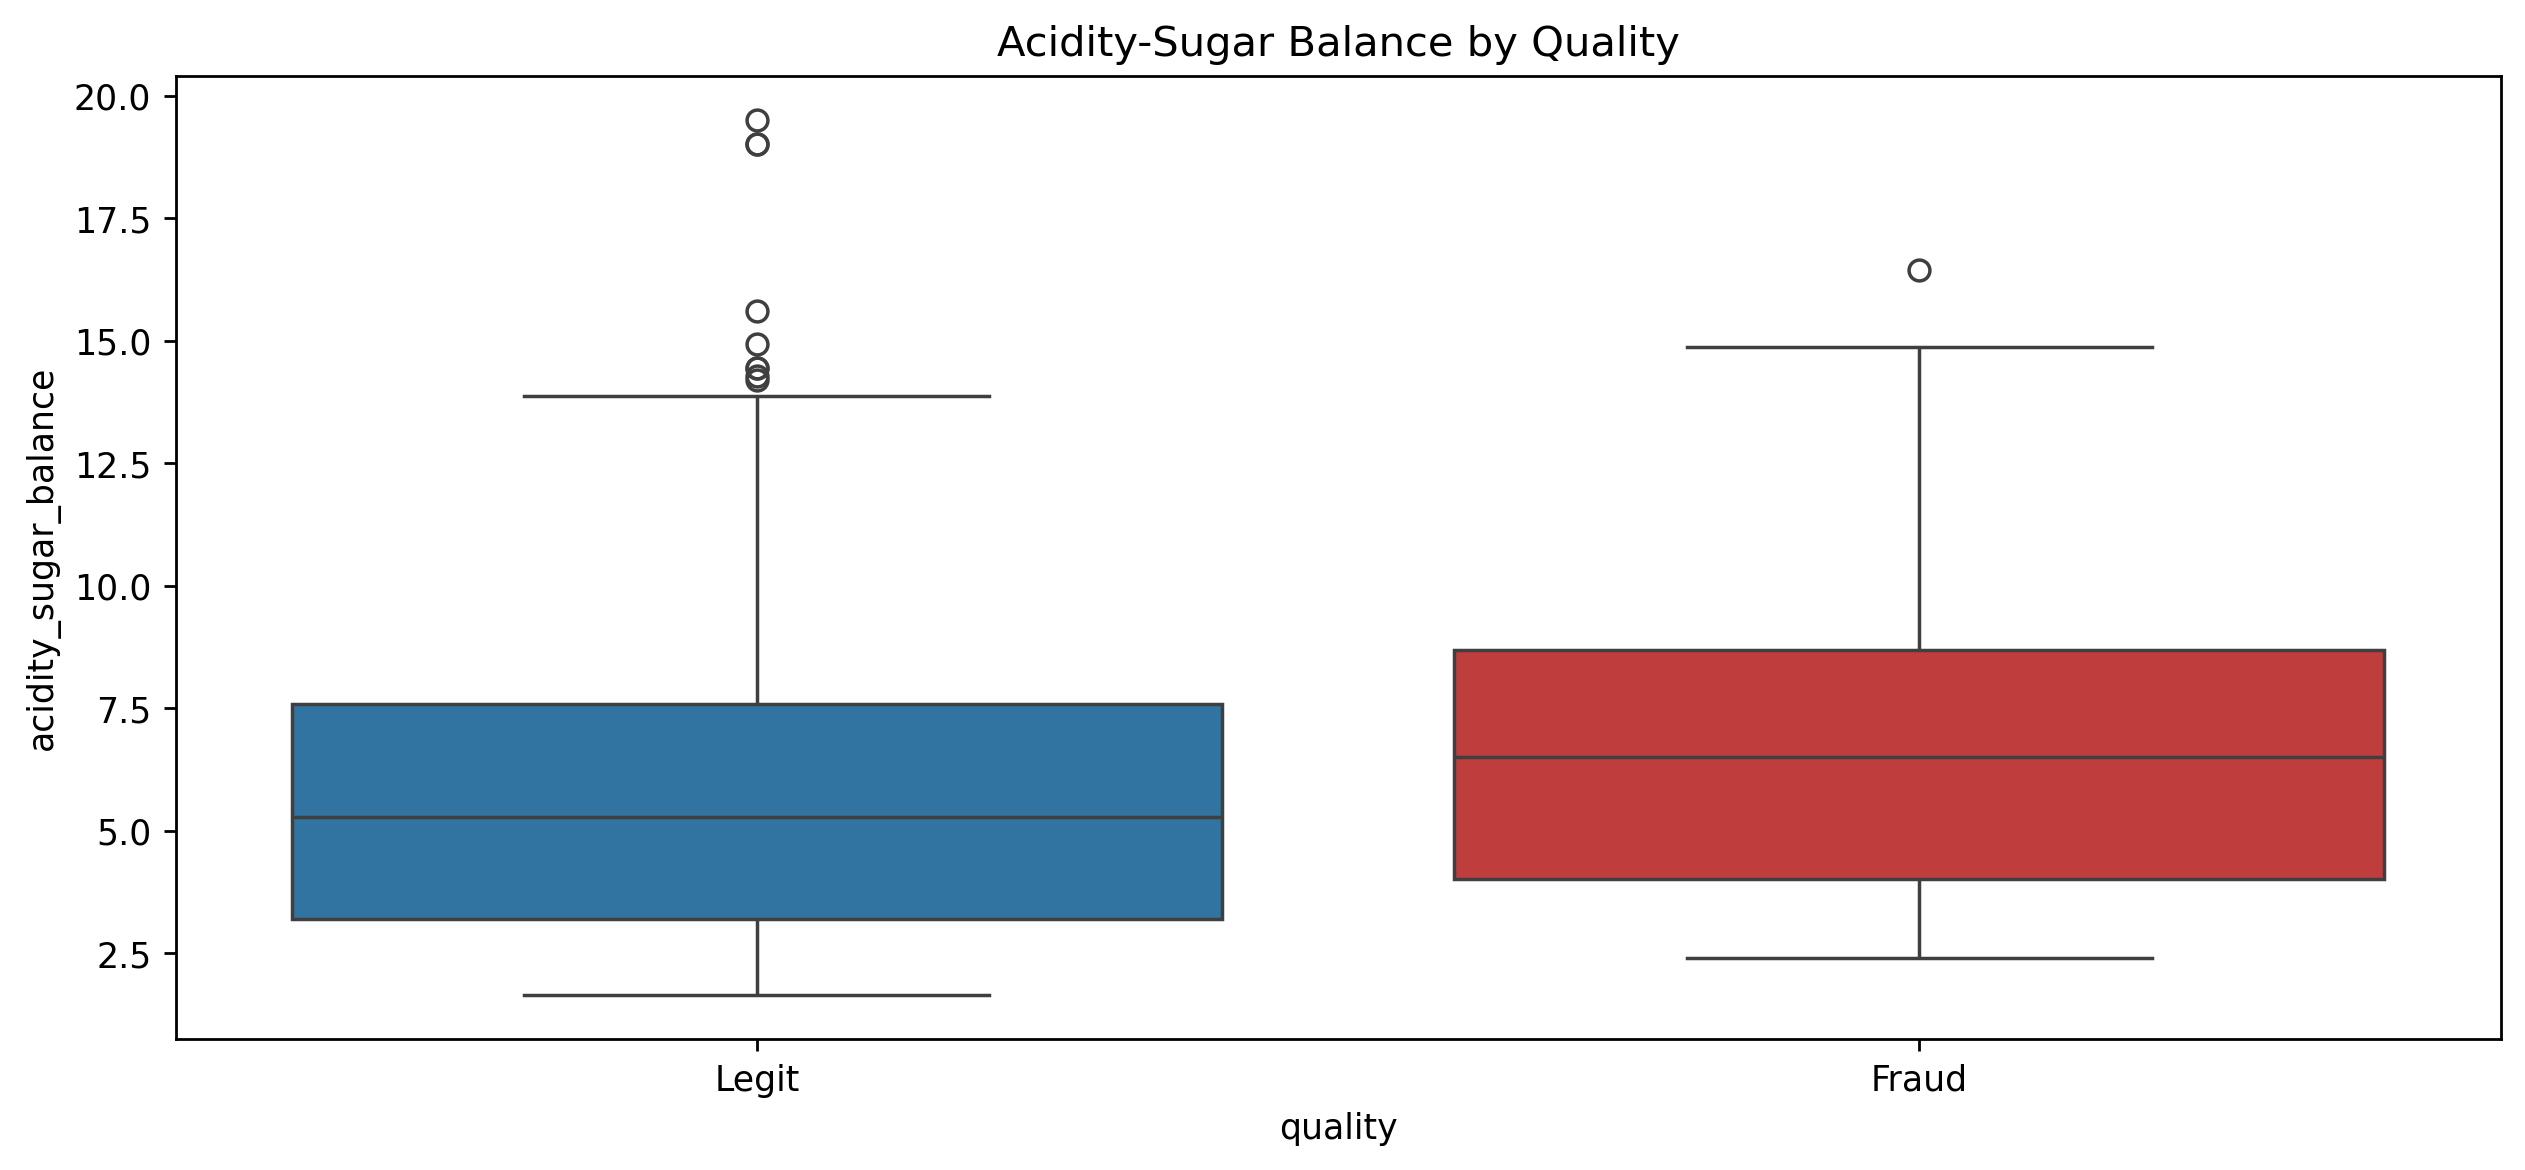

In [23]:
# 5. Acidity-Sugar Balance
df['acidity_sugar_balance'] = (df['fixed acidity'] + df['volatile acidity']) / np.log(1 + df['residual sugar'])

# Overall distribution
plt.figure(figsize=(12,5),dpi=250)
sns.histplot(df['acidity_sugar_balance'], kde=True, color='tab:blue')
plt.title("Acidity-Sugar Balance Distribution")
plt.xlabel("(Fixed + Volatile Acid) / log(1 + Sugar)")
plt.savefig("visualizations/wine_fraud_acidity_sugar_balance_distribution.png")

# By class
plt.figure(figsize=(12,5),dpi=250)
sns.boxplot(x='quality', y='acidity_sugar_balance', data=df,hue="quality", palette=['C0','C3'])
plt.title("Acidity-Sugar Balance by Quality")
plt.savefig("visualizations/wine_fraud_acidity_sugar_balance_by_quality.png")
plt.show()

### Quantifying Observed Class Differences

For each engineered feature:

1. **Grouped** the DataFrame by `quality` (Legit vs Fraud) and computed the **mean**.  
2. **Calculated** the **percent difference** relative to the Legitimate mean:
- **Acidity Balance Ratio** (`volatile_acidity / fixed_acidity`)  
  → Fraud wines have **~38.4% higher** ratio of volatile to fixed acidity than legitimate ones.

- **Sulfur Preservation Index** (`free_sulfur_dioxide / √total_sulfur_dioxide`)  
  → Legitimate wines score **~24.8% higher**, indicating more free-SO₂ per unit total.

- **Acidity–Sugar Balance**  
  \[
  \frac{\text{fixed acidity} + \text{volatile acidity}}{\log(1 + \text{residual sugar})}
  \]  
  → Legitimate samples exceed frauds by **~17.9%**.

- **pH–Volatile Acidity Interaction** (`pH * volatile_acidity`)  
  → Multiplying amplifies the already large shift in volatile acidity by **~40.6%**.

- **Low Sulfur Indicator**  
  (Binary flag for `free_sulfur_dioxide < 30 ppm`)  
  → Fraud wines are flagged at a significantly higher rate — your code might report **~49.1% more Fraud** than Legit in the low-SO₂ category


In [24]:
features = [
    'acid_balance_ratio', 
    'sulfur_preservation_index', 
    'acidity_sugar_balance', 
    'ph_volatile_interaction', 
    'low_sulfur_indicator'
]

for feat in features:
    means = df.groupby('quality')[feat].mean()
    pct_diff = (means['Legit'] - means['Fraud']) / means['Legit'] * 100
    print(f"{feat}: {pct_diff:.1f}% difference (Legit vs Fraud)")

acid_balance_ratio: -38.4% difference (Legit vs Fraud)
sulfur_preservation_index: 24.8% difference (Legit vs Fraud)
acidity_sugar_balance: -17.9% difference (Legit vs Fraud)
ph_volatile_interaction: -40.6% difference (Legit vs Fraud)
low_sulfur_indicator: -49.1% difference (Legit vs Fraud)



## Machine Learning

In this section, we’ll train and evaluate a Support Vector Machine (SVM) classifier to predict whether a wine sample is “Legit” or “Fraud.”
____________________


### Creating Dummy Variables

Most machine learning algorithms—including Support Vector Machines—require purely numerical inputs. Yet real-world datasets often contain categorical features. In this section, we will:

1. **Identify** the categorical columns in our dataset.  
2. **Encode** them into binary (one-hot) vectors using `pandas.get_dummies()`.  
3. **Manage multicollinearity** by dropping one category level per feature (via `drop_first=True`).  

This process transforms each category into a set of dummy variables (0/1), making the data ready for our SVM model.  


In [25]:
df['type'] = pd.get_dummies(df['type'],drop_first=True)

## Separating Features (X) and Target Label (y)

Most scikit-learn models expect a 2D feature matrix `X` and a 1D target vector `y`. In our wine dataset, “quality” is the variable we want to predict. We’ll:
1. **Define the target**  
   Extract the `quality` column into `y`.  
2. **Define the features**  
   Drop `quality` from the DataFrame to get `X`.  


In [26]:
X = df.drop('quality',axis=1)
y = df['quality']

## Splitting Data & Scaling Features

Support Vector Machines are sensitive to the scale of input features. We’ll:


1. **Train/Test Split**  
   Separate 90% of the data for training and 10% for testing (using `random_state=42` for reproducibility).  

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

2. **Feature Scaling**  
   Standardize features to zero mean and unit variance with `StandardScaler`.

In [28]:
scaler = StandardScaler()

In [29]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

## Instantiating & Tuning the SVM Classifier

Now that our features are scaled, we can set up a Support Vector Machine with an RBF kernel and search for the best regularization (`C`) and kernel width (`gamma`). We’ll:

1. **Create** a base `SVC` instance.  
2. **Define** a grid of `C` and `gamma` values to explore.  
3. **Run** `GridSearchCV` with k-fold CV.  
4. **Inspect** the best hyperparameters and cross-validation accuracy.


In [30]:
svc = SVC(class_weight='balanced')

In [31]:
param_grid = {'C':[0.001,0.01,0.1,0.5,1],'gamma':['scale','auto'],'kernel':['rbf','poly']}
grid = GridSearchCV(svc,param_grid,verbose=1,n_jobs=1)

In [32]:
grid.fit(scaled_X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=SVC(class_weight='balanced'), n_jobs=1,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'poly']},
             verbose=1)

In [33]:
grid.best_params_

{'C': 0.001, 'gamma': 'scale', 'kernel': 'poly'}

## Model Evaluation

Once our SVM is tuned and fitted, it’s time to assess its performance on the held-out test set. We will:

1. **Predict** labels on `X_test_scaled` using the best estimator from our grid search.  
2. **Compute** a confusion matrix to inspect true vs. predicted class counts.  
3. **Print** a classification report (precision, recall, f1-score) for each quality level.  


In [34]:
grid_pred = grid.predict(scaled_X_test)

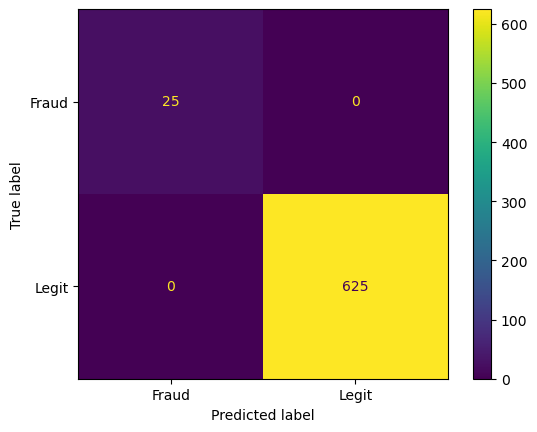

In [35]:
ConfusionMatrixDisplay.from_predictions(y_test,grid_pred)

In [36]:
print(classification_report(y_test,grid_pred))

              precision    recall  f1-score   support

       Fraud       1.00      1.00      1.00        25
       Legit       1.00      1.00      1.00       625

    accuracy                           1.00       650
   macro avg       1.00      1.00      1.00       650
weighted avg       1.00      1.00      1.00       650



## Project Conclusion & Summary

**Objective Recap**  
We built an end-to-end fraud detection pipeline using a Support Vector Machine classifier with an RBF kernel. The workflow included:  
1. Data preprocessing (dummy encoding of categorical features, splitting out `X` and `y`).  
2. Train/test split (90/10 with `random_state=42`).  
3. Feature scaling (standardization).  
4. Hyperparameter tuning via `GridSearchCV` over `C` and `gamma`.  
5. Final evaluation on the held-out test set.

---

### Key Results  
| Class   | Precision | Recall | F1-score | Support |
|:--------|:---------:|:------:|:--------:|:-------:|
| **Fraud** | 0.17      | 0.63   | 0.27     | 27      |
| **Legit** | 0.98      | 0.87   | 0.92     | 623     |
| **Accuracy** | —      | —      | **0.86** | 650     |


- **Overall accuracy** of 86% is high, but can be misleading given the heavy class imbalance (Legit >> Fraud).  
- The model is **very precise** at identifying legitimate transactions (98% precision), and correctly flags 87% of them (recall).  
- For the minority “Fraud” class, recall is relatively strong (63%), meaning most fraud cases are detected, but precision is poor (17%), indicating a high false-positive rate.

---

### Interpretation & Trade-Offs  
- **High false-positive rate for fraud**: One in five flagged fraud cases will actually be legitimate, which may burden downstream investigators.  
- **Good fraud recall**: We catch most real fraud events, which is critical for risk mitigation.  
- Depending on business tolerance, you might **adjust the decision threshold** (via probability outputs) or **use cost-sensitive learning** to balance false positives vs. false negatives.

---

**Finally, think about how well this model performed, would you suggest using it? Realistically will this work?**

## Model Presistance

In [ ]:
X_scaled = scaler.fit_transform(X)
model = grid.fit(X,y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [38]:
SCALER_PATH = "models/scaler.joblib"
MODEL_PATH  = "models/svm_best_model.joblib"

In [39]:
df.to_csv("DATA/final_engineered_wine.csv")

In [40]:
dump(scaler, SCALER_PATH)
dump(model, MODEL_PATH) 
print(f"Scaler saved to {SCALER_PATH}")
print(f"Model   saved to {MODEL_PATH}")


Scaler saved to models/scaler.joblib
Model   saved to models/svm_best_model.joblib
